**QDM diagnostics: testing interpolation methods on one grid cell using real data (CMIP6 model and ERA-5)**

In [1]:
import intake
import xarray as xr
import os 
import pandas as pd
import numpy as np
import zarr 
import rhg_compute_tools.kubernetes as rhgk

from xclim.core.calendar import convert_calendar

import warnings
warnings.filterwarnings("ignore")

In [2]:
client, cluster = rhgk.get_standard_cluster()
cluster.scale(10)

In [3]:
client

<Client: 'tls://10.20.8.2:8786' processes=0 threads=0, memory=0 B>

In [299]:
cluster.close()

Get CMIP6 data from GCS. Here we're going to get daily `tmax` from `ACCESS-ESM1-5` for historical and SSP370 runs. 

In [4]:
activity_id = 'ScenarioMIP'
experiment_id = 'ssp370'
table_id = 'day'
variable_id = 'tasmax'
source_id = 'ACCESS-ESM1-5' # 'IPSL-CM6A-LR'
institution_id = 'NCAR'
member_id = 'r1i1p1f1'

Pull the CMIP6 data

In [5]:
# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

cat = col.search(activity_id=['CMIP', activity_id], 
                 experiment_id=['historical', experiment_id], table_id=table_id, variable_id=variable_id,
                 source_id=source_id, member_id=member_id)

In [6]:
ds_model = {}
ds_model['historical'] = cat['CMIP.CSIRO.ACCESS-ESM1-5.historical.day.gn'].to_dask().isel(member_id=0
                                                                                       ).squeeze(drop=True).drop(['member_id',
                                                                                                                  'height'])

In [7]:
ds_model['ssp370'] = cat['ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp370.day.gn'].to_dask().isel(member_id=0
                                                                                       ).squeeze(drop=True).drop(['member_id',
                                                                                                                  'height'])

Define the historical and simulated datasets

In [298]:
hist_ds = ds_model['historical']
sim_ds = ds_model['ssp370']

Pull in tasmax from ERA-5 for the reference dataset from 1995-2014

In [10]:
filenames = []
yrs = np.arange(1994,2016) 
    
for num_yrs in range(len(yrs)):
    filename = '/gcs/impactlab-data/climate/source_data/ERA-5/day/tmax/v1.1/tmax_daily_{}-{}.nc'.format(yrs[num_yrs], yrs[num_yrs])
    filenames.append(filename)
    
era5_tmax = xr.open_mfdataset(filenames, concat_dim='time', combine='by_coords')

ref_ds = era5_tmax

In [12]:
# Select a single grid point for analysis -- Denver, CO or Miami, FL
lat = 40.0 #25.78
lon = 260.0 #280.0

ref_da = ref_ds['tmax'].sel(latitude=lat, longitude=lon, method='nearest')
hist_da = hist_ds['tasmax'].sel(lat=lat, lon=lon, method='nearest')
sim_da = sim_ds['tasmax'].sel(lat=lat, lon=lon, method='nearest')

In [297]:
# Select the appropriate time period with the +/- 15 day window for grouping
ref_da = ref_da.sel(time=slice('1994-12-17','2015-01-15'))
hist_da = hist_da.sel(time=slice('1994-12-17','2014-12-31'))

In [14]:
# get the extra 15 days needed for a full rolling time series
hist_ex = sim_da.sel(time=slice('2015-01-01','2015-01-15'))
sim_ex = hist_da.sel(time=slice('2014-12-17','2014-12-31'))

In [15]:
#Concatenate the extra periods with the full timeseries
hist_all = xr.concat([hist_da, hist_ex], dim='time')
sim_all = xr.concat([sim_ex, sim_da], dim='time')

In [16]:
# remove leap days and convert calendar to no-leap
ref = convert_calendar(ref_da, 'noleap')
hist = convert_calendar(hist_all, 'noleap')
sim = convert_calendar(sim_all, 'noleap')

In [18]:
ref = ref.load()
hist = hist.load()
sim = sim.load()

Load necessary packages, etc. for QDM implementation

In [19]:
! pip install git+https://github.com/ClimateImpactLab/xclim 

  Cloning https://github.com/ClimateImpactLab/xclim to /tmp/pip-req-build-vmopt2x0


In [20]:
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import dask
import dask.array as da
import dask.distributed as dd
import xclim
from xclim import sdba
from scipy.stats import scoreatpercentile
from scipy.stats.kde import gaussian_kde

from xclim.testing.tests.test_sdba import utils as tu

In [21]:
write_direc = '../figures/'

In [22]:
nquantiles = 100 #620 is empirical
kind = "+"

if kind=='*':
    kindstr='mult'
else:
    kindstr='add'

In [23]:
grouper = "time.dayofyear"
window = 31 

grouper = sdba.Grouper(grouper, window=window)

QMdg = sdba.adjustment.EmpiricalQuantileMapping(kind=kind, group=grouper, nquantiles=nquantiles)
QMdg.train(ref, hist) #(ref, hist)  

DQMdg = sdba.adjustment.DetrendedQuantileMapping(kind=kind, group=grouper, nquantiles=nquantiles)
DQMdg.train(ref, hist)

QDMdg = sdba.adjustment.QuantileDeltaMapping(kind=kind, group=grouper, nquantiles=nquantiles)
QDMdg.train(ref, hist)

Testing interpolation methods

In [24]:
hist_qdm = QDMdg.adjust(hist, interp='nearest')
sim_qdm = QDMdg.adjust(sim, interp='nearest')

hist_qdm_lin = QDMdg.adjust(hist, interp='linear')
sim_qdm_lin = QDMdg.adjust(sim, interp='linear')

hist_qdm_cub = QDMdg.adjust(hist, interp='cubic')
sim_qdm_cub = QDMdg.adjust(sim, interp='cubic')

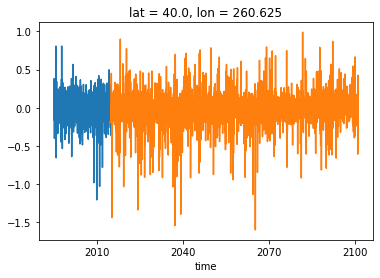

In [25]:
(hist_qdm_lin - hist_qdm).plot()
(sim_qdm_lin - sim_qdm).plot()

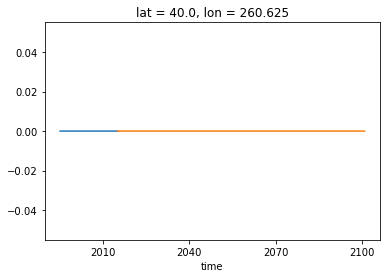

In [26]:
(hist_qdm_lin - hist_qdm_cub).plot()
(sim_qdm_lin - sim_qdm_cub).plot()

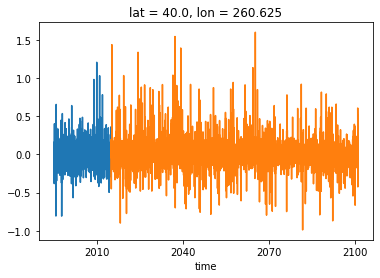

In [27]:
(hist_qdm - hist_qdm_cub).plot()
(sim_qdm - sim_qdm_cub).plot()

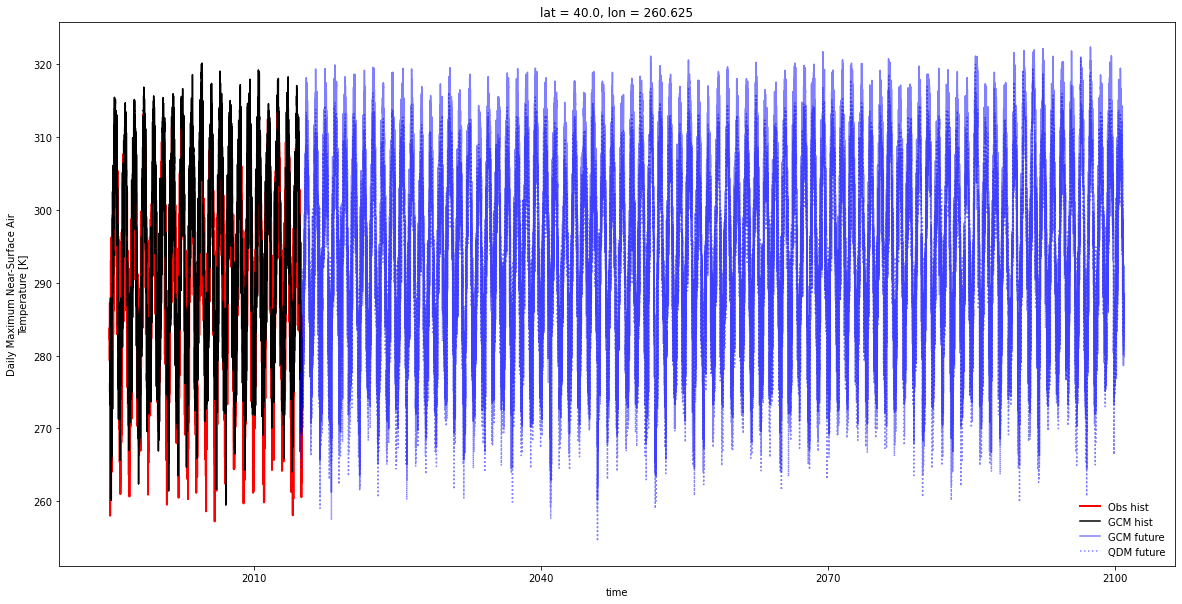

In [28]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ref.plot(ax=ax, linewidth=2, color="r", label="Obs hist")
hist.plot(ax=ax, color="k", label="GCM hist")
sim.plot(ax=ax, color="blue", label="GCM future", alpha=.5)
sim_qdm.plot(ax=ax, linestyle=':', color="blue", label="QDM future", alpha=.5)
ax.legend(frameon=False)

In [29]:
print('all days linear trend')
print('  sim    ', sp.stats.linregress(np.arange(len(sim.time)), sim.values).slope*len(sim.time)) # total change
print('  QDM sim', sp.stats.linregress(np.arange(len(sim_qdm.time)), sim_qdm.values).slope*len(sim_qdm.time)) # total change

all days linear trend
  sim     3.596158653904617
  QDM sim 3.9513410401853344


**Rolling CDF**

In [30]:
simy_qdm_list = []
simy_qdm_lin_list = []
simy_qdm_cub_list = []

roll = 10

# because we're rolling, we can't use the first and last 10 years
bc_years = np.arange(sim.time.dt.year.values[0]+roll,sim.time.dt.year.values[-1]-roll)

for yr in bc_years:
    timeslice = slice(str(yr-roll-1)+'-12-17',str(yr+roll+1)+'-01-15')
    
    # testing this on a future with a trend and one without
    simy_qdm_list.append(QDMdg.adjust(sim.sel(time=timeslice), interp='nearest', year=yr))
    simy_qdm_lin_list.append(QDMdg.adjust(sim.sel(time=timeslice), interp='linear', year=yr))
    simy_qdm_cub_list.append(QDMdg.adjust(sim.sel(time=timeslice), interp='cubic', year=yr))

simy_qdm = xr.concat(simy_qdm_list, dim='time')
simy_lin_qdm = xr.concat(simy_qdm_lin_list, dim='time')
simy_cub_qdm = xr.concat(simy_qdm_cub_list, dim='time')

Plots of the CDFs comparing the interpolation methods

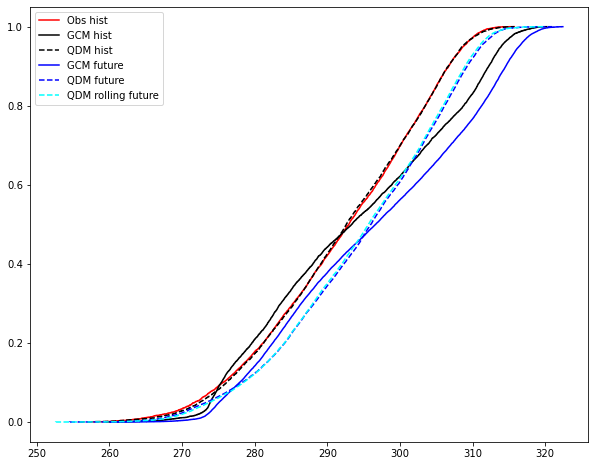

In [31]:
# interp = nearest
import statsmodels.api as sm
    
ref_ecdf = sm.distributions.ECDF(ref)
hist_ecdf = sm.distributions.ECDF(hist)
sim_ecdf = sm.distributions.ECDF(sim)
histqdm_ecdf = sm.distributions.ECDF(hist_qdm)
simqdm_ecdf = sm.distributions.ECDF(sim_qdm)
simyqdm_ecdf = sm.distributions.ECDF(simy_qdm)

fig,ax = plt.subplots(1,1,figsize=(10,8))

ax.step(ref_ecdf.x,ref_ecdf.y, color="r", label="Obs hist")
ax.step(hist_ecdf.x,hist_ecdf.y, color="k", label="GCM hist")
ax.step(histqdm_ecdf.x,histqdm_ecdf.y, color="k", linestyle='dashed', label="QDM hist")
ax.step(sim_ecdf.x,sim_ecdf.y, color="blue", label="GCM future")
ax.step(simqdm_ecdf.x,simqdm_ecdf.y, color="blue", linestyle='dashed', label="QDM future")
ax.step(simyqdm_ecdf.x,simyqdm_ecdf.y, color="cyan", linestyle='dashed', label="QDM rolling future")
ax.legend()

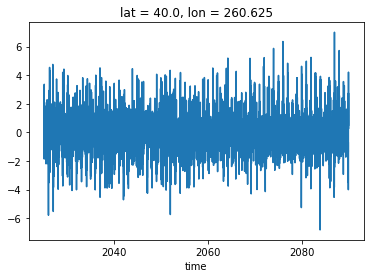

In [32]:
(sim_qdm.sel(time=slice('2025-01-01','2089-12-31')) - simy_qdm).plot()

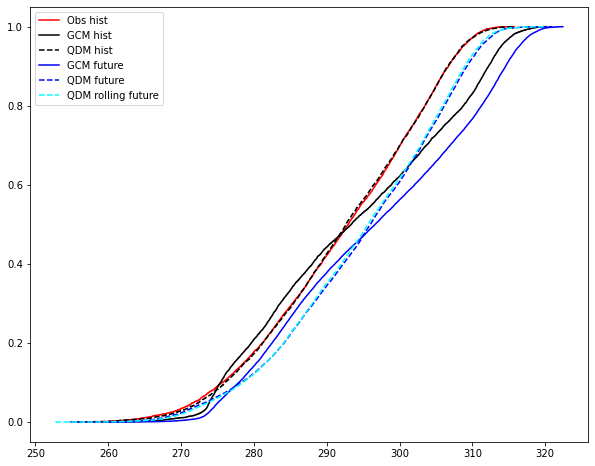

In [33]:
# interp = linear

ref_ecdf = sm.distributions.ECDF(ref)
hist_ecdf = sm.distributions.ECDF(hist)
sim_ecdf = sm.distributions.ECDF(sim)
histqdm_ecdf_lin = sm.distributions.ECDF(hist_qdm_lin)
simqdm_ecdf_lin = sm.distributions.ECDF(sim_qdm_lin)
simyqdm_ecdf_lin = sm.distributions.ECDF(simy_lin_qdm)

fig,ax = plt.subplots(1,1,figsize=(10,8))

ax.step(ref_ecdf.x,ref_ecdf.y, color="r", label="Obs hist")
ax.step(hist_ecdf.x,hist_ecdf.y, color="k", label="GCM hist")
ax.step(histqdm_ecdf_lin.x,histqdm_ecdf_lin.y, color="k", linestyle='dashed', label="QDM hist")
ax.step(sim_ecdf.x,sim_ecdf.y, color="blue", label="GCM future")
ax.step(simqdm_ecdf_lin.x,simqdm_ecdf_lin.y, color="blue", linestyle='dashed', label="QDM future")
ax.step(simyqdm_ecdf_lin.x,simyqdm_ecdf_lin.y, color="cyan", linestyle='dashed', label="QDM rolling future")
ax.legend()

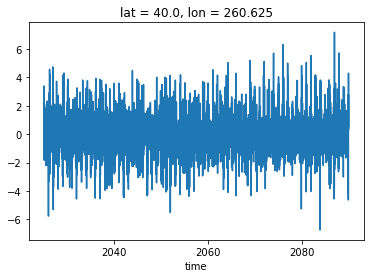

In [34]:
(sim_qdm_lin.sel(time=slice('2025-01-01','2089-12-31')) - simy_lin_qdm).plot()

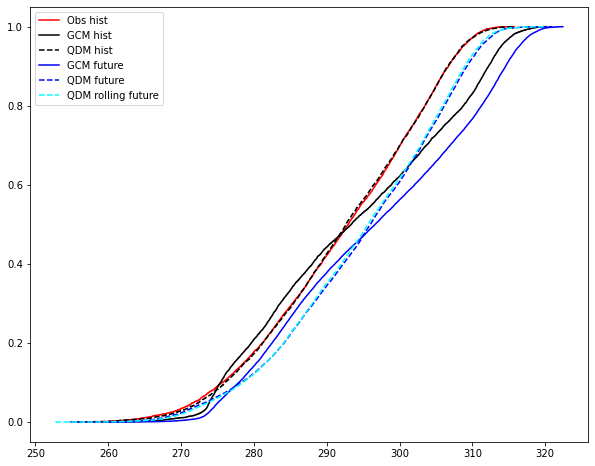

In [35]:
# interp = cubic

import statsmodels.api as sm
    
ref_ecdf = sm.distributions.ECDF(ref)
hist_ecdf = sm.distributions.ECDF(hist)
sim_ecdf = sm.distributions.ECDF(sim)
histqdm_ecdf_cub = sm.distributions.ECDF(hist_qdm_cub)
simqdm_ecdf_cub = sm.distributions.ECDF(sim_qdm_cub)
simyqdm_ecdf_cub = sm.distributions.ECDF(simy_cub_qdm)

fig,ax = plt.subplots(1,1,figsize=(10,8))

ax.step(ref_ecdf.x,ref_ecdf.y, color="r", label="Obs hist")
ax.step(hist_ecdf.x,hist_ecdf.y, color="k", label="GCM hist")
ax.step(histqdm_ecdf_cub.x,histqdm_ecdf_cub.y, color="k", linestyle='dashed', label="QDM hist")
ax.step(sim_ecdf.x,sim_ecdf.y, color="blue", label="GCM future")
ax.step(simqdm_ecdf_cub.x,simqdm_ecdf_cub.y, color="blue", linestyle='dashed', label="QDM future")
ax.step(simyqdm_ecdf_cub.x,simyqdm_ecdf_cub.y, color="cyan", linestyle='dashed', label="QDM rolling future")
ax.legend()

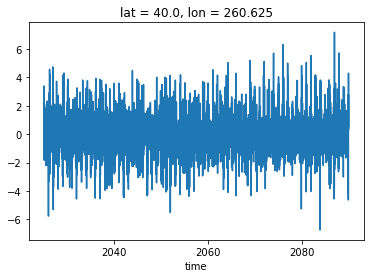

In [36]:
(sim_qdm_cub.sel(time=slice('2025-01-01','2089-12-31')) - simy_cub_qdm).plot()

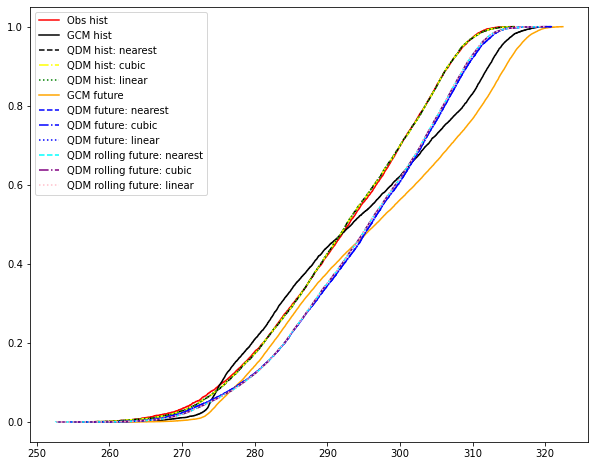

In [37]:
# All interp methods and single vs rolling CDFs
fig,ax = plt.subplots(1,1,figsize=(10,8))

ax.step(ref_ecdf.x,ref_ecdf.y, color="r", label="Obs hist")
ax.step(hist_ecdf.x,hist_ecdf.y, color="k", label="GCM hist")

# different interp methods
ax.step(histqdm_ecdf.x,histqdm_ecdf.y, color="k", linestyle='dashed', label="QDM hist: nearest")
ax.step(histqdm_ecdf_cub.x,histqdm_ecdf_cub.y, color="yellow", linestyle='-.', label="QDM hist: cubic")
ax.step(histqdm_ecdf_lin.x,histqdm_ecdf_lin.y, color="green", linestyle='dotted', label="QDM hist: linear")

ax.step(sim_ecdf.x,sim_ecdf.y, color="orange", label="GCM future")
ax.step(simqdm_ecdf.x,simqdm_ecdf.y, color="blue", linestyle='dashed', label="QDM future: nearest")
ax.step(simqdm_ecdf_cub.x,simqdm_ecdf_cub.y, color="blue", linestyle='-.', label="QDM future: cubic")
ax.step(simqdm_ecdf_lin.x,simqdm_ecdf_lin.y, color="blue", linestyle='dotted', label="QDM future: linear")

ax.step(simyqdm_ecdf.x,simyqdm_ecdf.y, color="cyan", linestyle='dashed', label="QDM rolling future: nearest")
ax.step(simyqdm_ecdf_cub.x,simyqdm_ecdf_cub.y, color="purple", linestyle='-.', label="QDM rolling future: cubic")
ax.step(simyqdm_ecdf_lin.x,simyqdm_ecdf_lin.y, color="pink", linestyle='dotted', label="QDM rolling future: linear")

ax.legend()

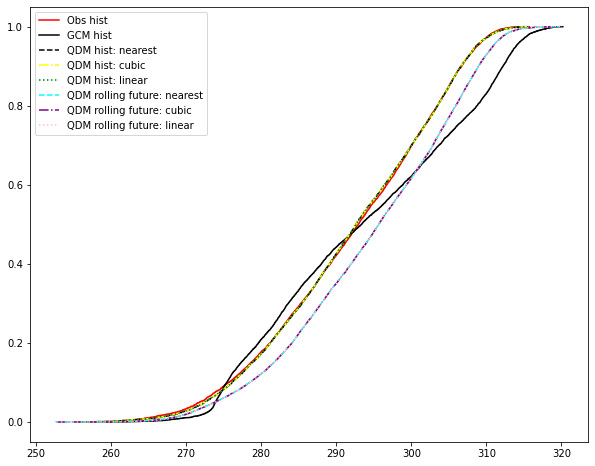

In [38]:
# All interp methods, only rolling CDFs
fig,ax = plt.subplots(1,1,figsize=(10,8))

ax.step(ref_ecdf.x,ref_ecdf.y, color="r", label="Obs hist")
ax.step(hist_ecdf.x,hist_ecdf.y, color="k", label="GCM hist")

# different interp methods
ax.step(histqdm_ecdf.x,histqdm_ecdf.y, color="k", linestyle='dashed', label="QDM hist: nearest")
ax.step(histqdm_ecdf_cub.x,histqdm_ecdf_cub.y, color="yellow", linestyle='-.', label="QDM hist: cubic")
ax.step(histqdm_ecdf_lin.x,histqdm_ecdf_lin.y, color="green", linestyle='dotted', label="QDM hist: linear")

ax.step(simyqdm_ecdf.x,simyqdm_ecdf.y, color="cyan", linestyle='dashed', label="QDM rolling future: nearest")
ax.step(simyqdm_ecdf_cub.x,simyqdm_ecdf_cub.y, color="purple", linestyle='-.', label="QDM rolling future: cubic")
ax.step(simyqdm_ecdf_lin.x,simyqdm_ecdf_lin.y, color="pink", linestyle='dotted', label="QDM rolling future: linear")

ax.legend()

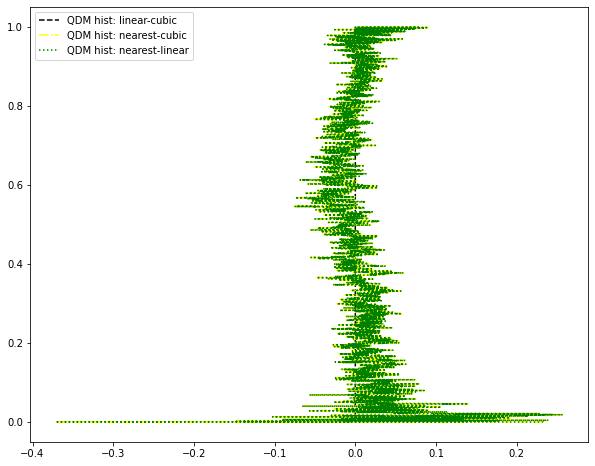

In [39]:
# Difference between historical CDFs across the interp methods
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.step((histqdm_ecdf_lin.x - histqdm_ecdf_cub.x),histqdm_ecdf.y, color="k", linestyle='dashed', label="QDM hist: linear-cubic")
ax.step((histqdm_ecdf.x - histqdm_ecdf_cub.x),histqdm_ecdf_cub.y, color="yellow", linestyle='-.', label="QDM hist: nearest-cubic")
ax.step((histqdm_ecdf.x - histqdm_ecdf_lin.x),histqdm_ecdf_lin.y, color="green", linestyle='dotted', label="QDM hist: nearest-linear")
ax.legend()

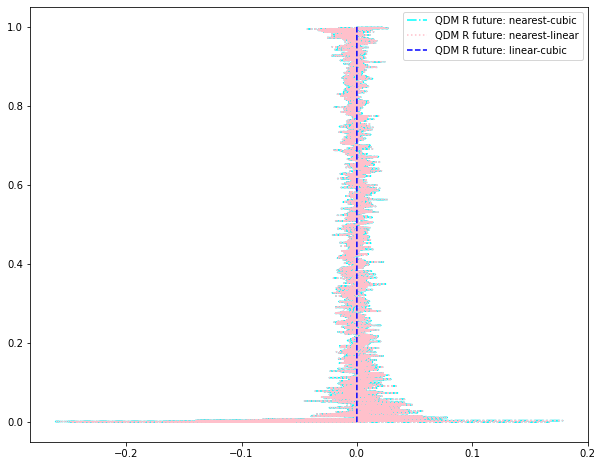

In [40]:
# Difference between future rolling CDFs across the interp methods
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.step((simyqdm_ecdf.x - simyqdm_ecdf_cub.x),simyqdm_ecdf_cub.y, color="cyan", linestyle='-.', label="QDM R future: nearest-cubic")
ax.step((simyqdm_ecdf.x - simyqdm_ecdf_lin.x),simyqdm_ecdf_lin.y, color="pink", linestyle='dotted', label="QDM R future: nearest-linear")
ax.step((simyqdm_ecdf_lin.x - simyqdm_ecdf_cub.x),simyqdm_ecdf.y, color="blue", linestyle='dashed', label="QDM R future: linear-cubic")
ax.legend()

In [41]:
print('all days linear trend')
print('  sim    ', sp.stats.linregress(np.arange(len(sim.time)), sim.values).slope*len(sim.time)) # total change
print('  QDM sim', sp.stats.linregress(np.arange(len(sim_qdm.time)), sim_qdm.values).slope*len(sim_qdm.time)) # total change
print('  QDM rolling sim', sp.stats.linregress(np.arange(len(simy_qdm.time)), simy_qdm.values).slope*len(simy_qdm.time)) # total change

all days linear trend
  sim     3.596158653904617
  QDM sim 3.9513410401853344
  QDM rolling sim 2.6845631443896867


**Are the trends preserved across quantiles?**

In [42]:
from plotting import quantile_compare_plot, compare_quantile_deltas_scatter_hist, compare_gcm_qdm_quantile_deltas, plot_quantile_delta_differences_by_group

Quantile number = 100 -- Denver, CO.

interp='nearest' (rolling CDFs)

In [43]:
# what are the best keys to use? 'GCM hist', 'QDM hist', 'GCM future','QDM future' or what is here?
raw_dict = {'ref':ref,
           'hist':hist,
           'sim':sim}
adjusted_dict = {'hist':hist_qdm,
                'sim':simy_qdm}
bcgrouper = QDMdg.group

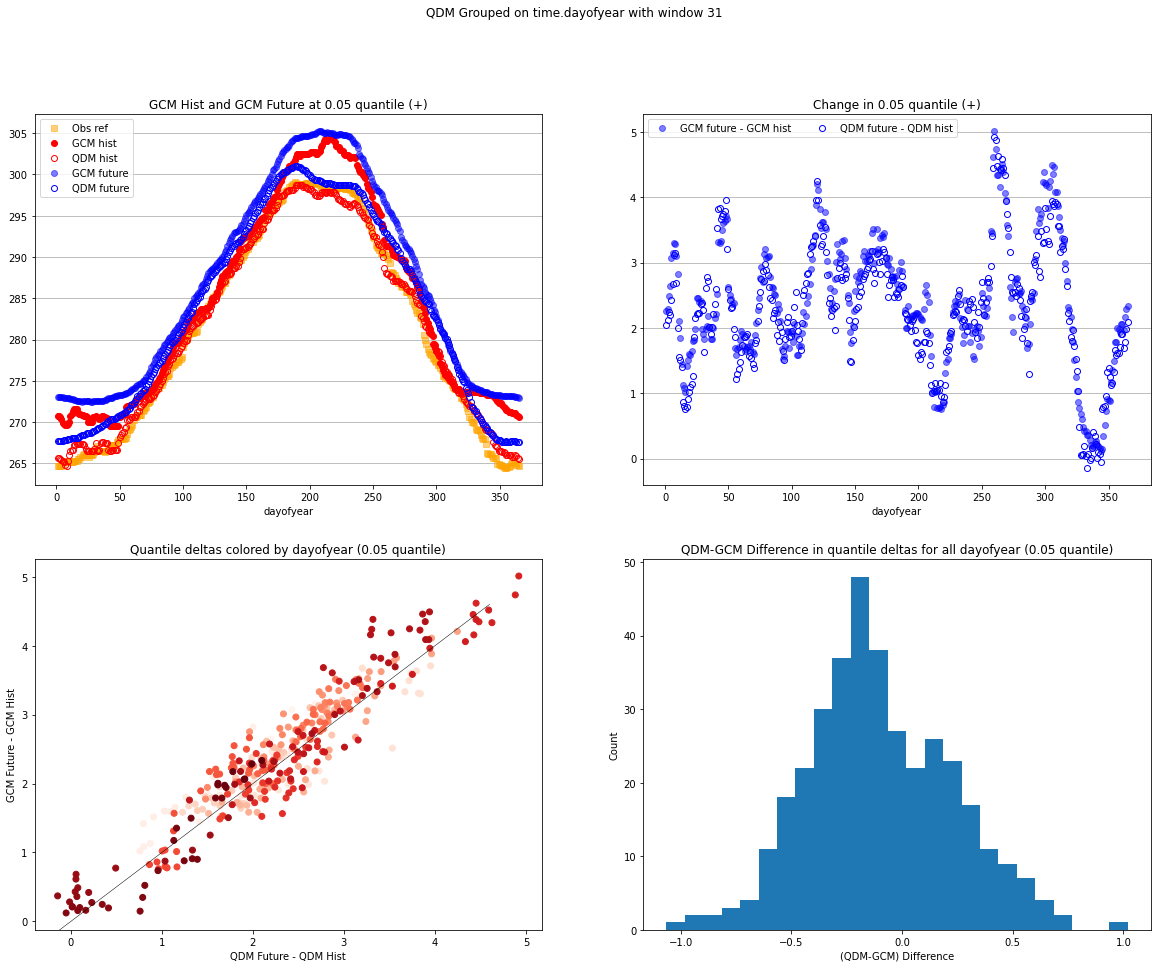

In [44]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.05], simple=True, tworow=True)

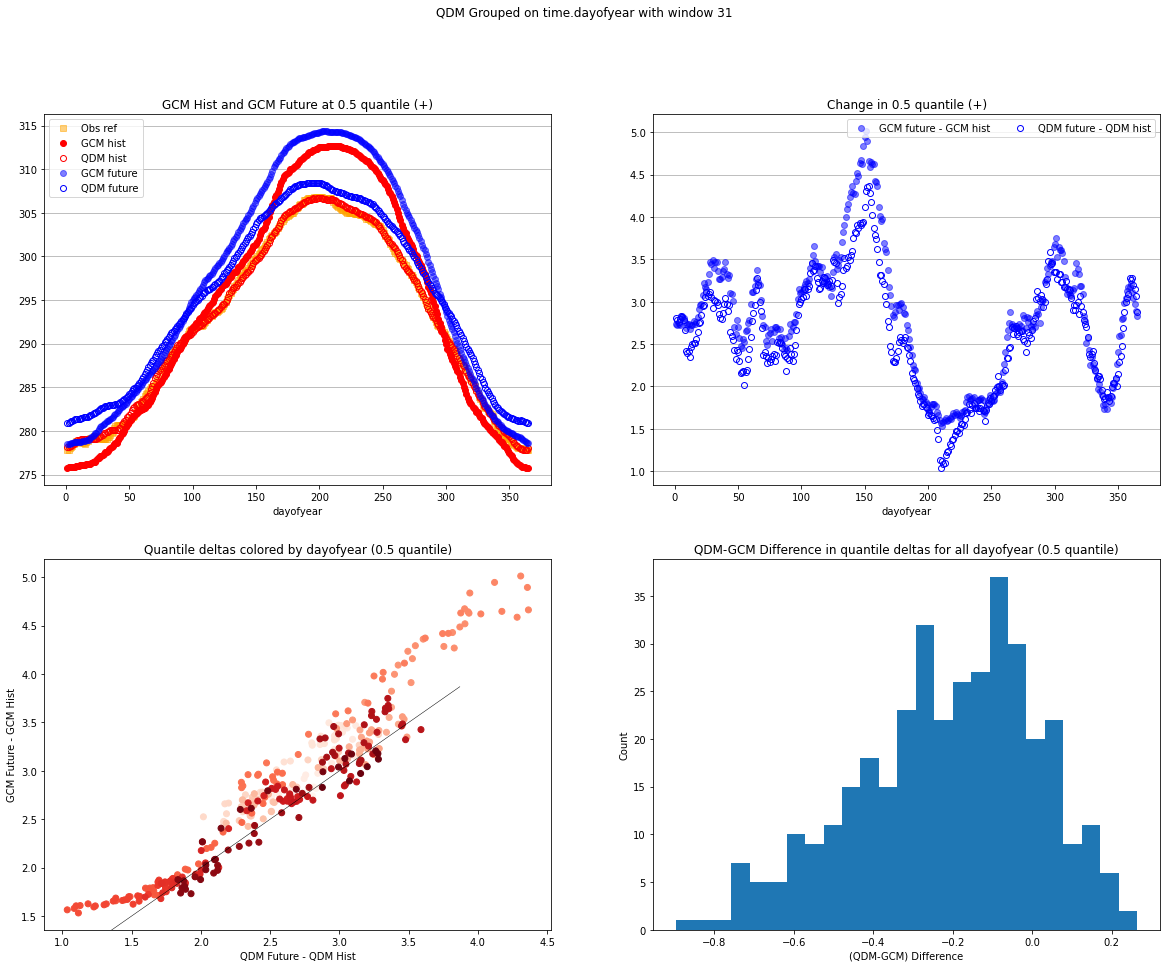

In [45]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.5], simple=True, tworow=True)

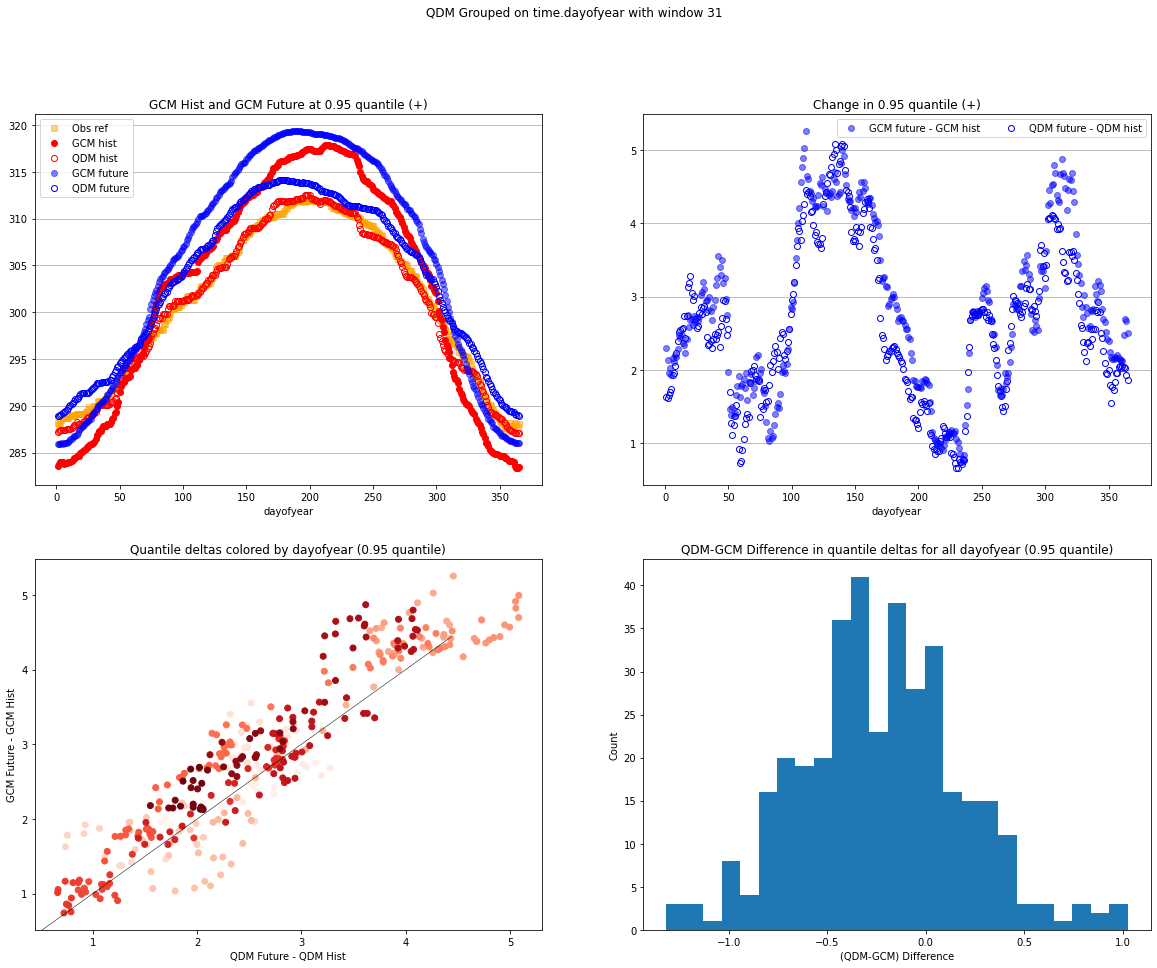

In [46]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.95], simple=True, tworow=True)

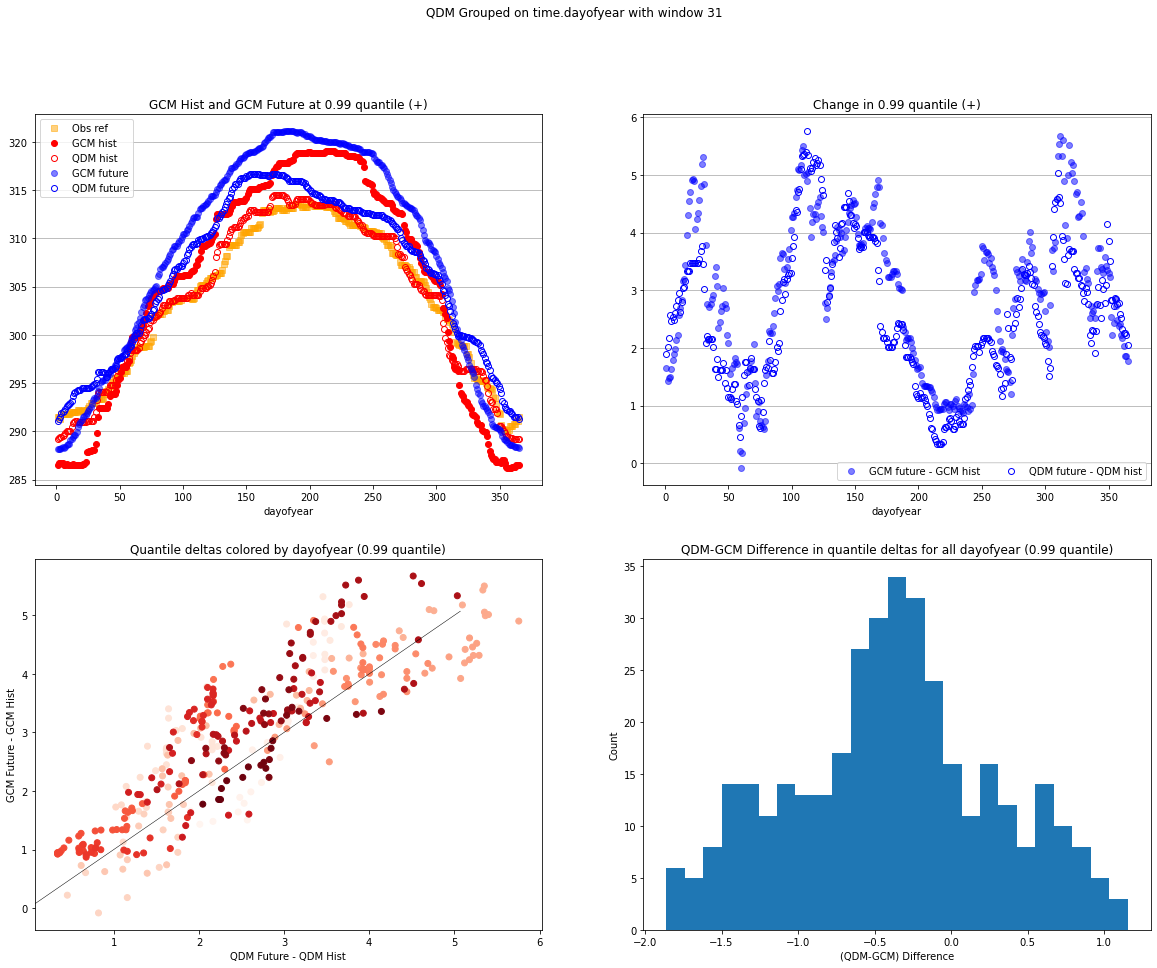

In [47]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

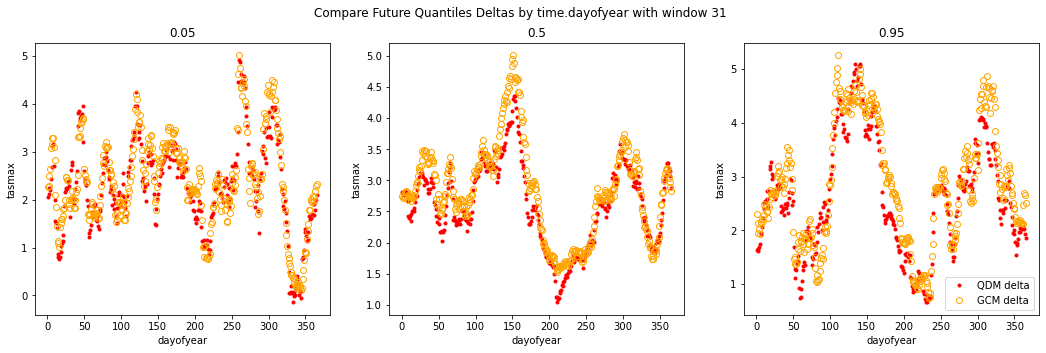

In [48]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

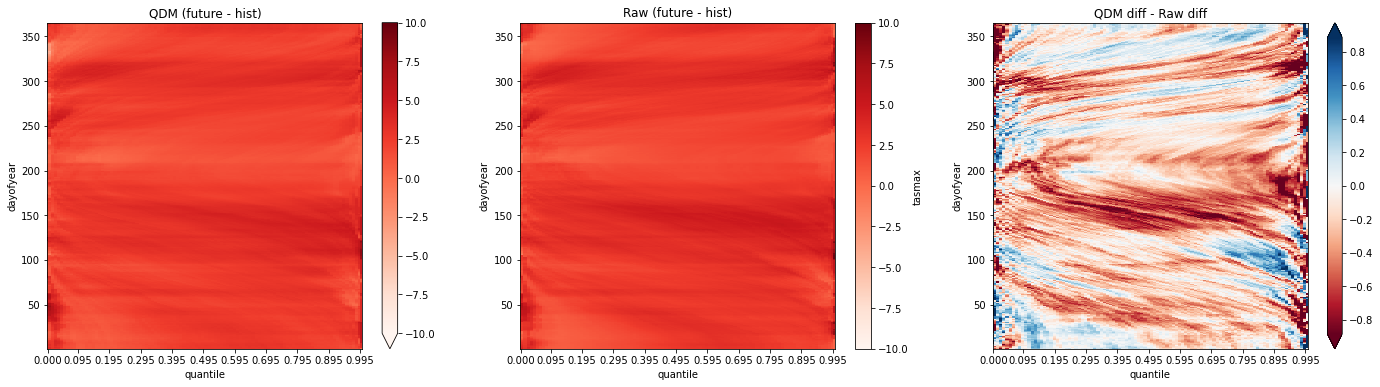

In [49]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=QDMdg.ds.quantiles)

interp='linear' (rolling CDFs)

In [50]:
# what are the best keys to use? 'GCM hist', 'QDM hist', 'GCM future','QDM future' or what is here?
raw_dict = {'ref':ref,
           'hist':hist,
           'sim':sim}
adjusted_dict = {'hist':hist_qdm_lin,
                'sim':simy_lin_qdm}
bcgrouper = QDMdg.group

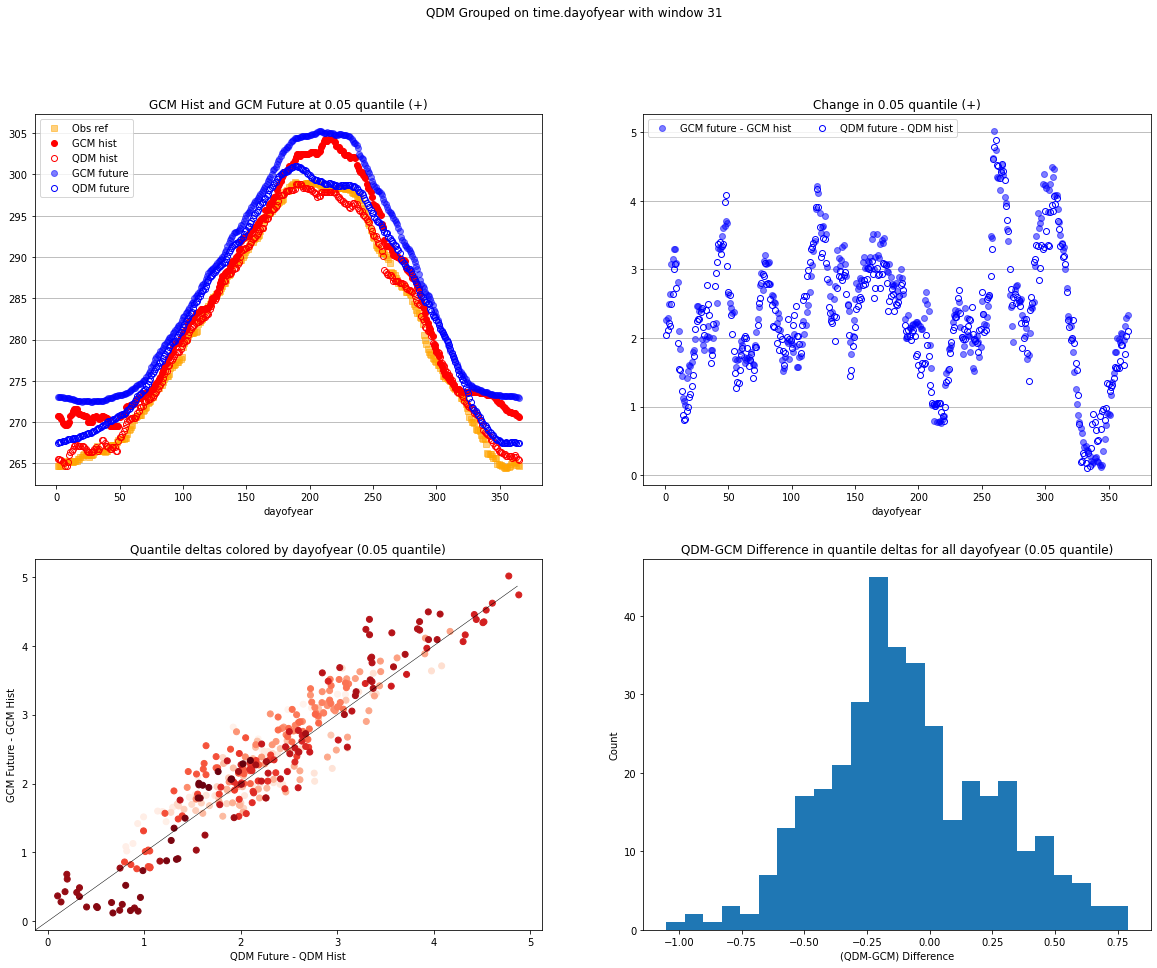

In [51]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.05], simple=True, tworow=True)

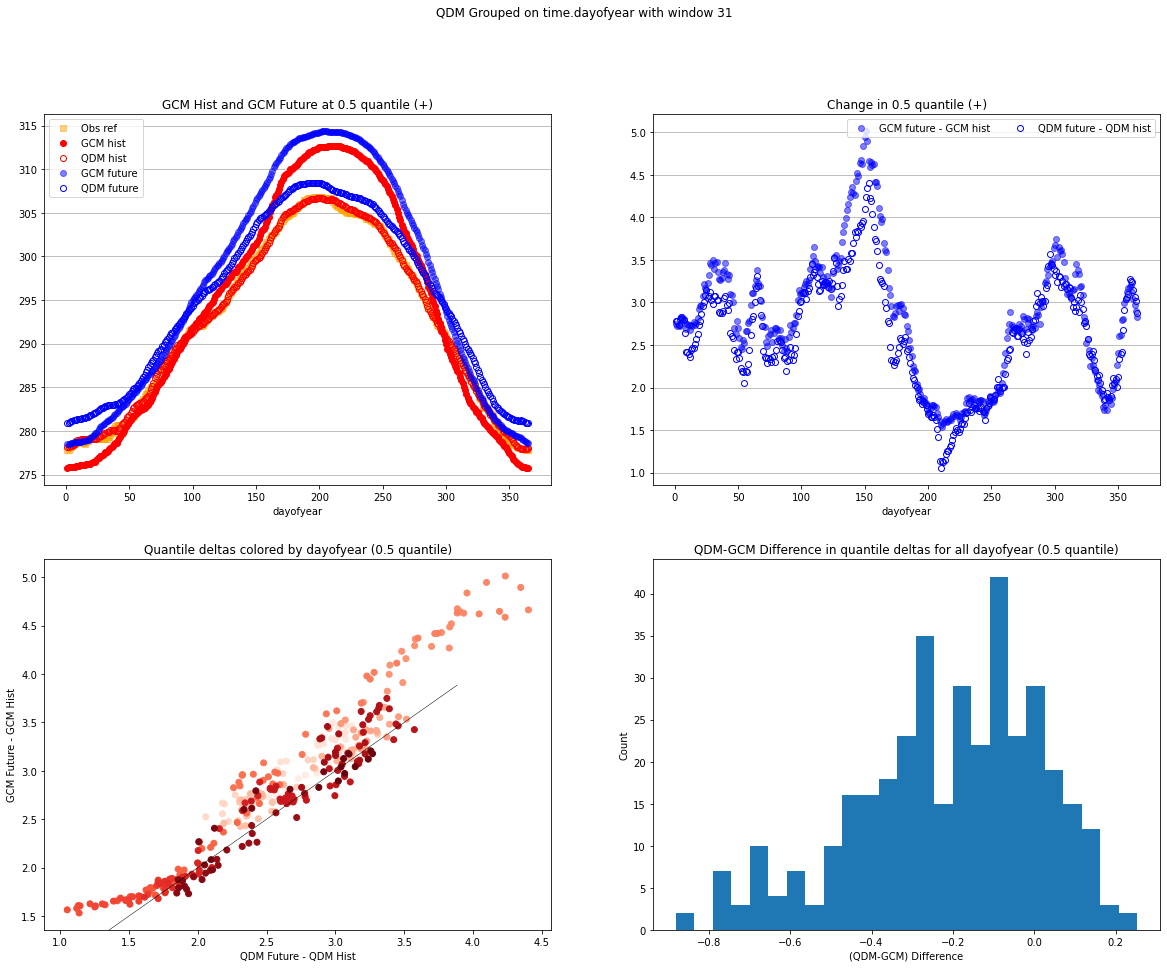

In [52]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.5], simple=True, tworow=True)

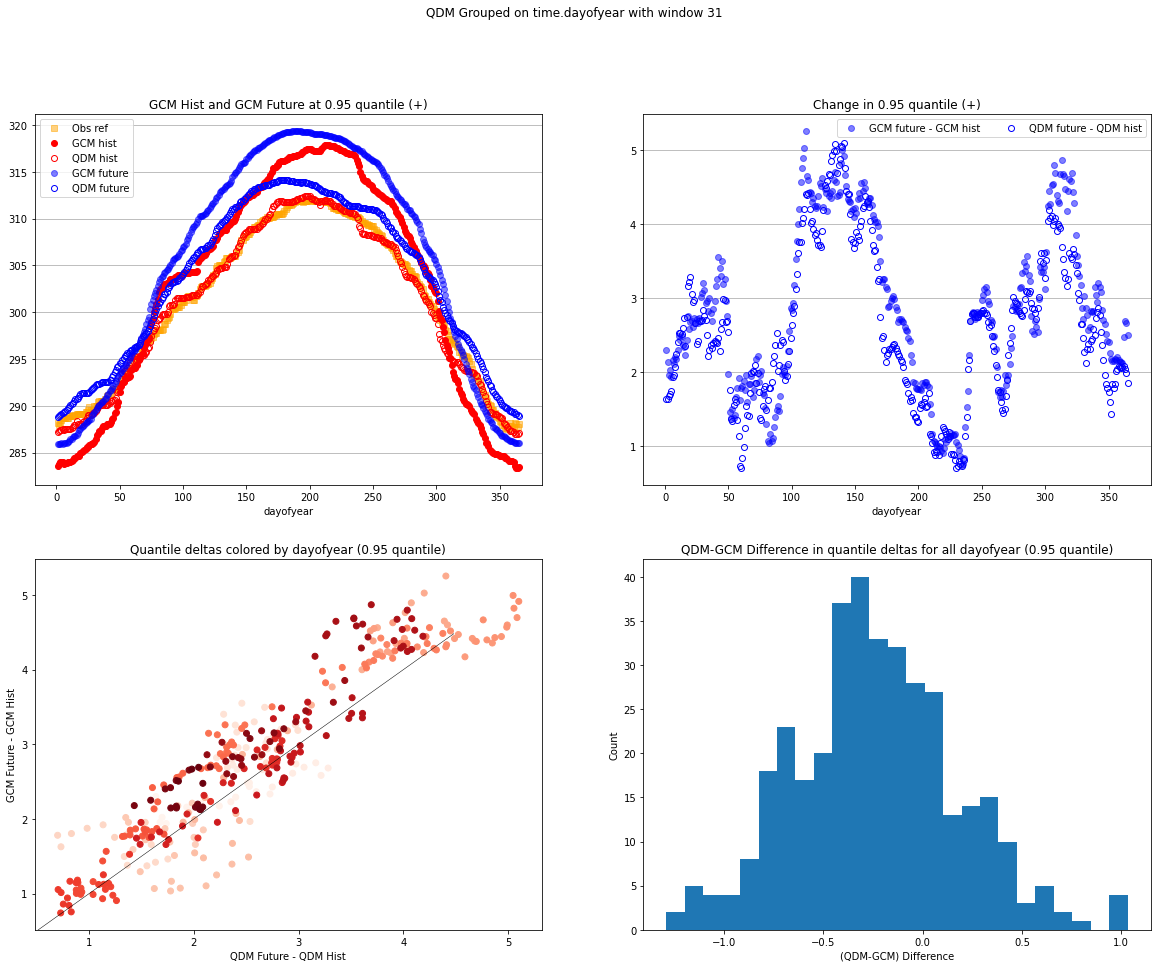

In [53]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.95], simple=True, tworow=True)

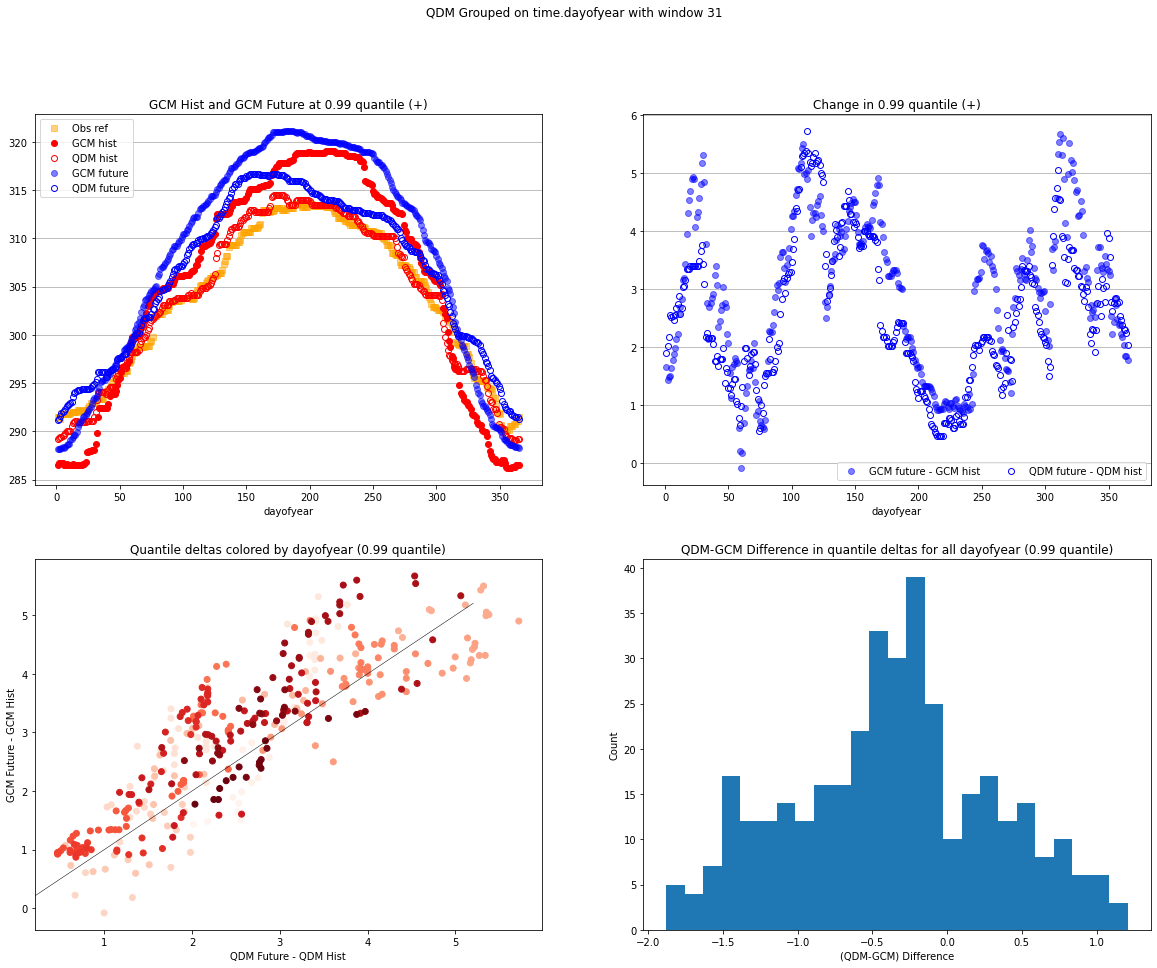

In [54]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

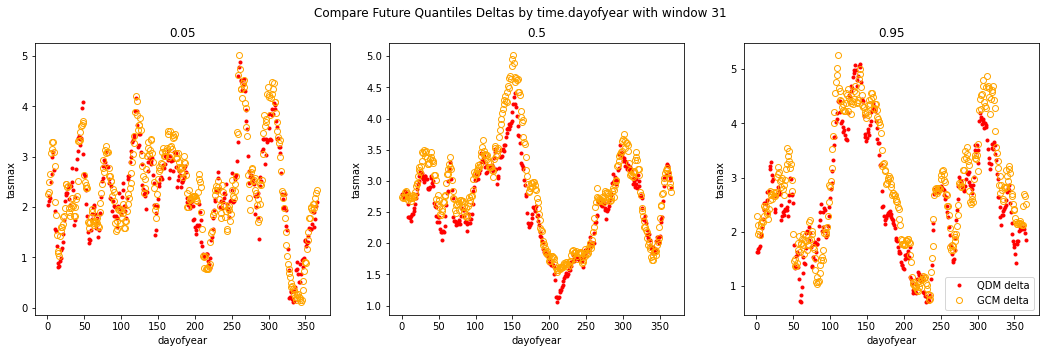

In [55]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

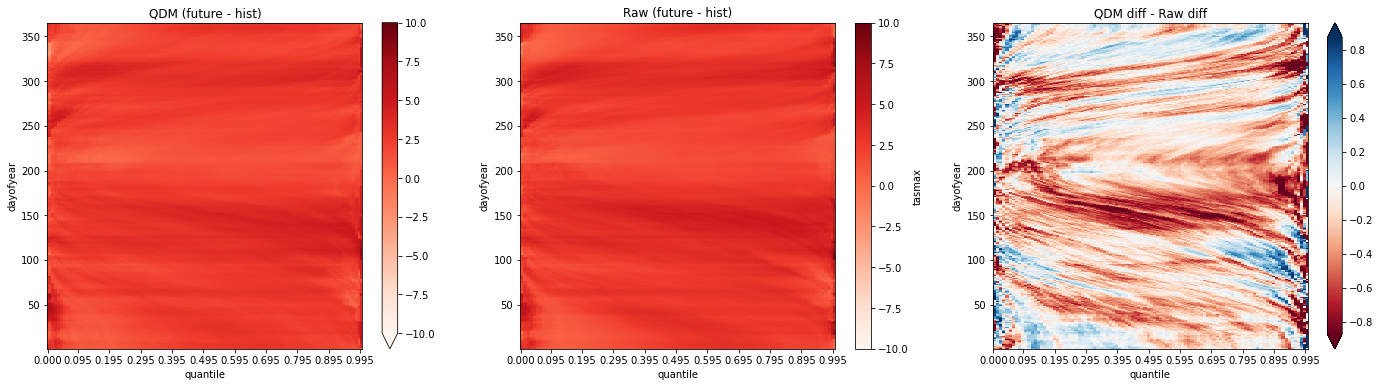

In [56]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=QDMdg.ds.quantiles)

interp='cubic' (rolling CDFs)

In [57]:
# what are the best keys to use? 'GCM hist', 'QDM hist', 'GCM future','QDM future' or what is here?
raw_dict = {'ref':ref,
           'hist':hist,
           'sim':sim}
adjusted_dict = {'hist':hist_qdm_cub,
                'sim':simy_cub_qdm}
bcgrouper = QDMdg.group

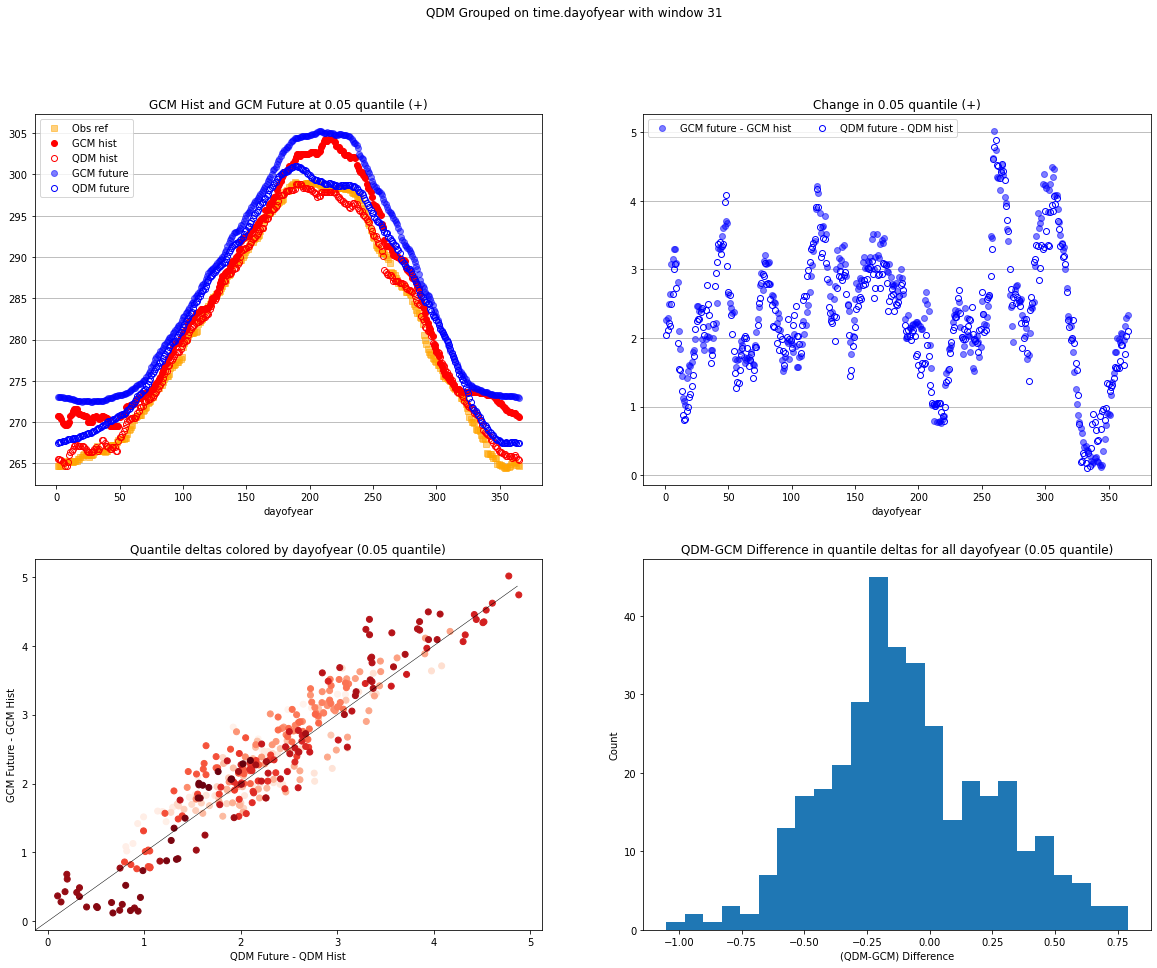

In [58]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.05], simple=True, tworow=True)

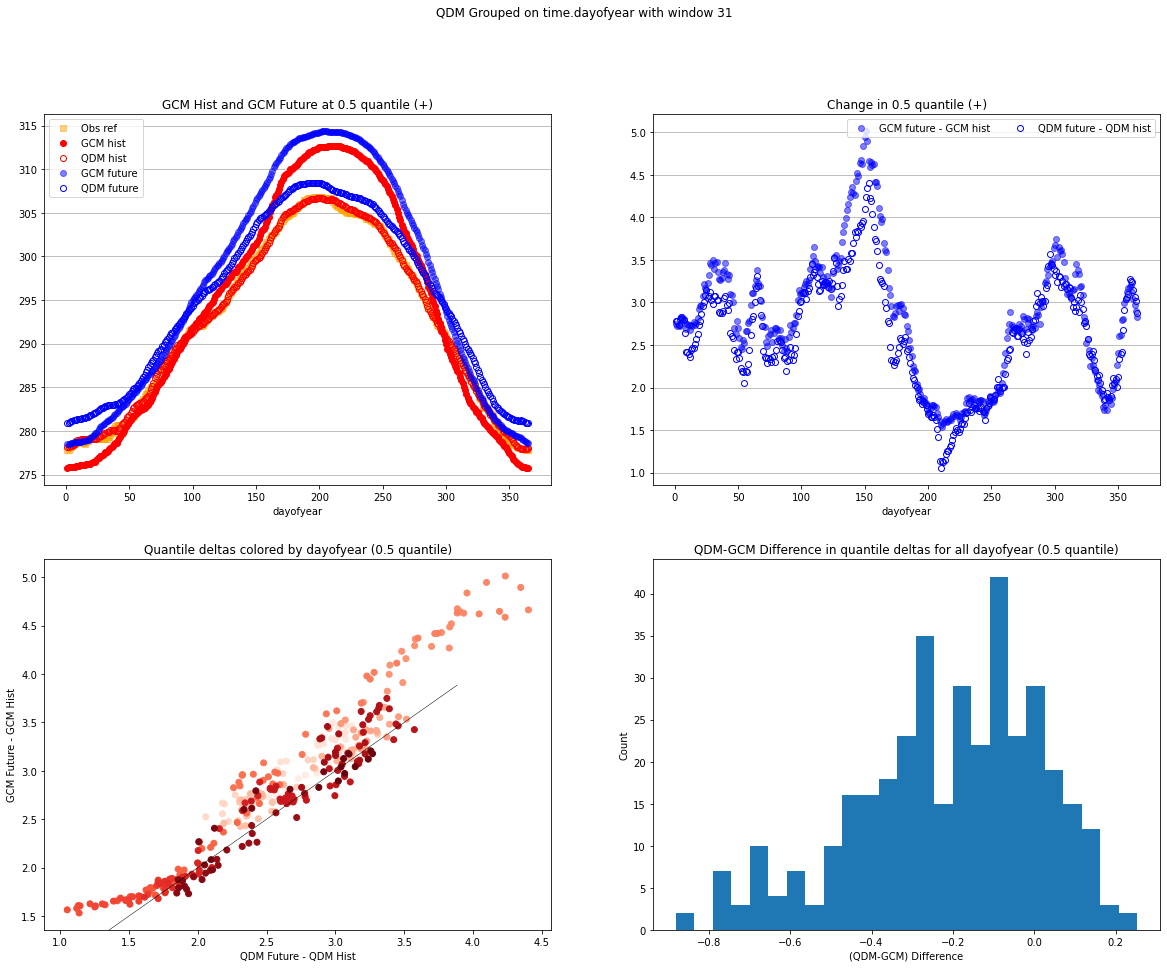

In [59]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.5], simple=True, tworow=True)

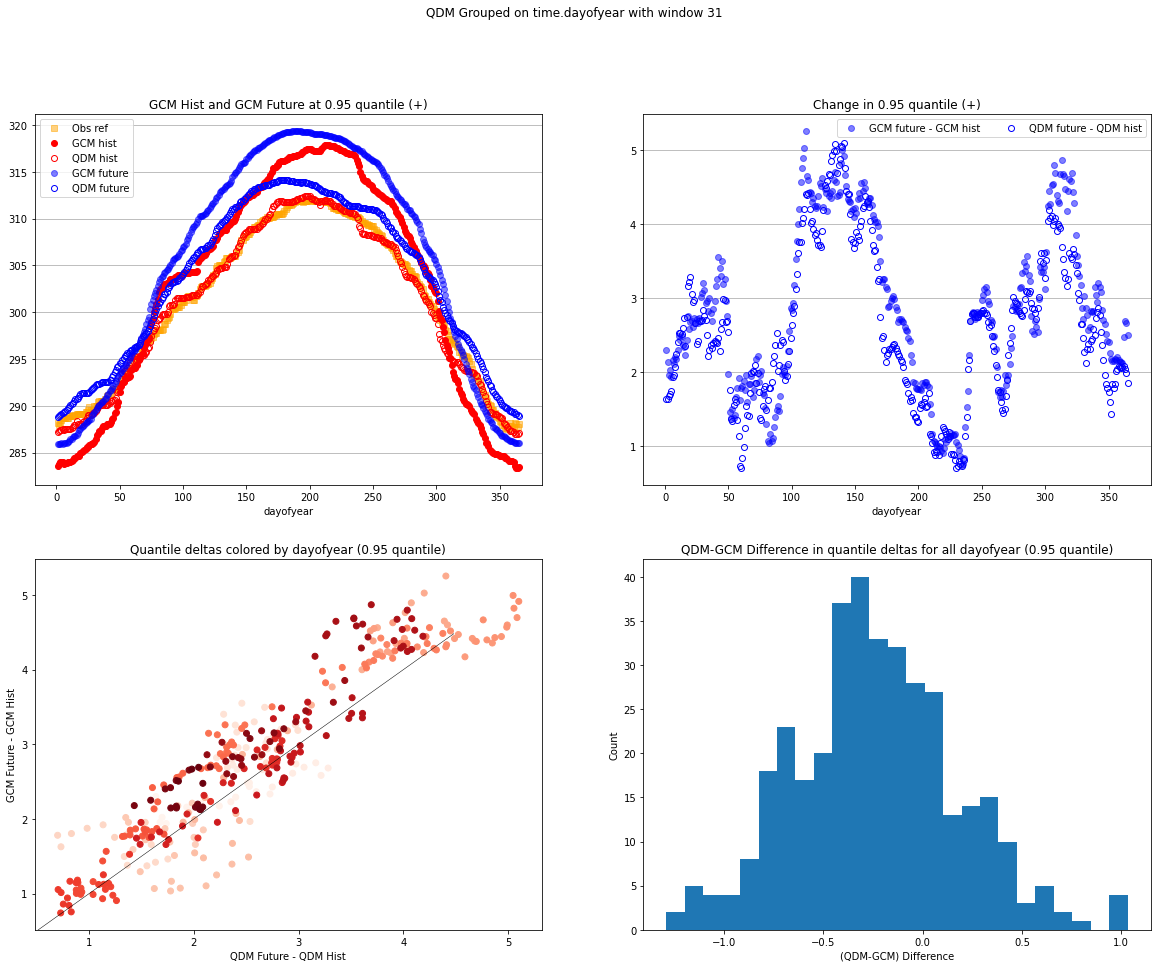

In [60]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.95], simple=True, tworow=True)

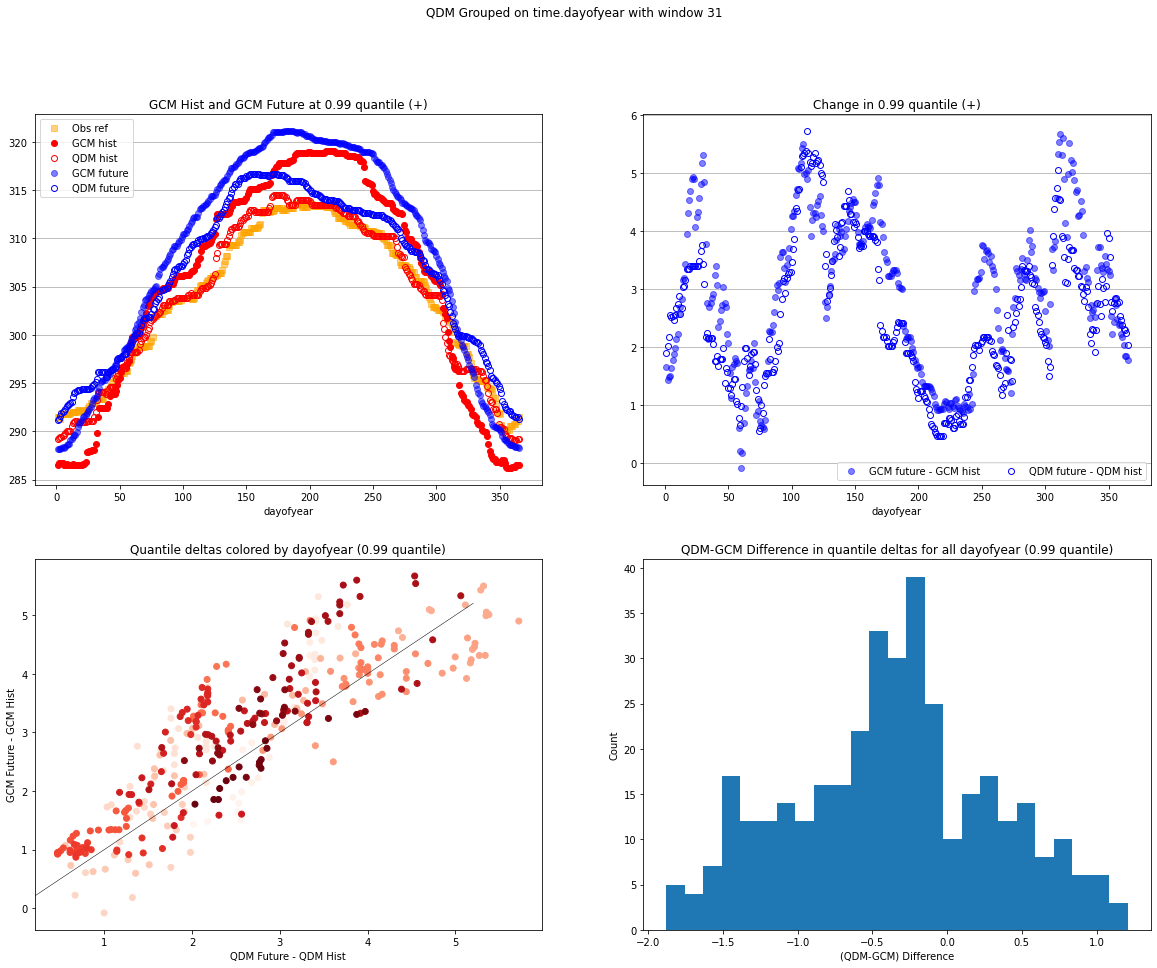

In [61]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

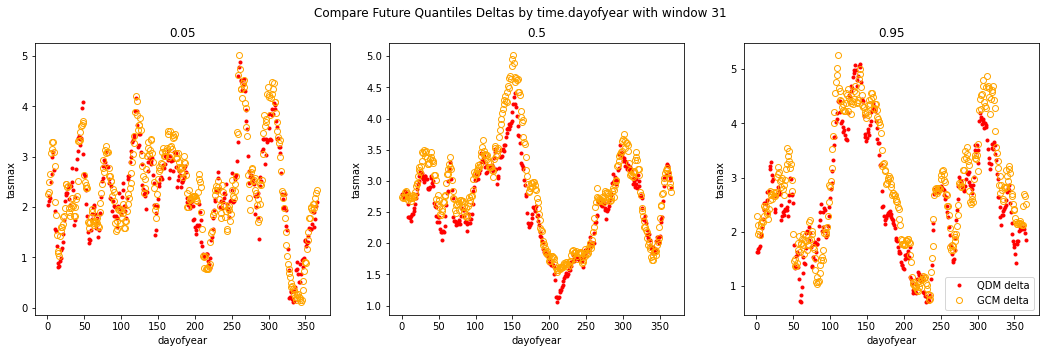

In [62]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

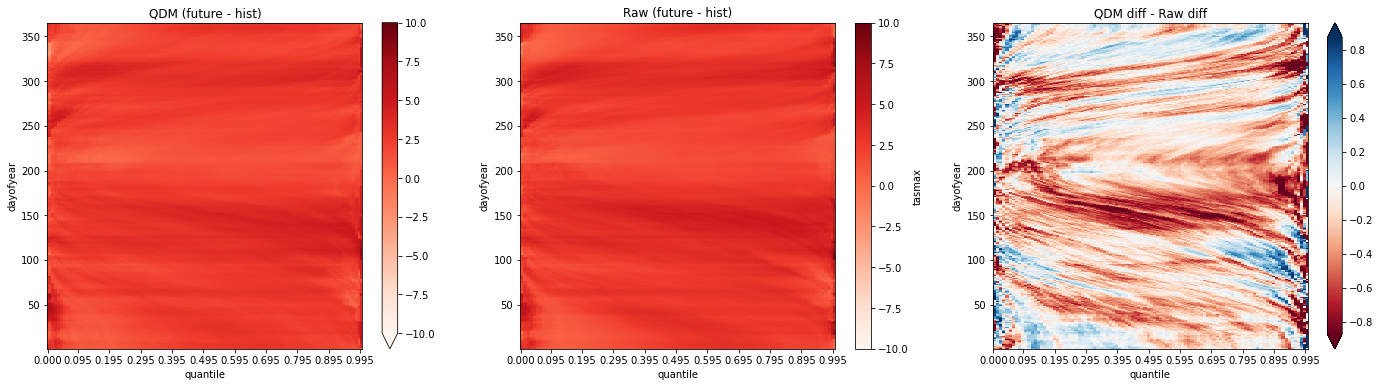

In [63]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=QDMdg.ds.quantiles)

Comparison between interp methods for a 20-yr period

interp='nearest' 2040-2060

In [64]:
# what are the best keys to use? 'GCM hist', 'QDM hist', 'GCM future','QDM future' or what is here?
raw_dict = {'ref':ref,
           'hist':hist,
           'sim':sim.loc[dict(time=slice("%s-01-01" %str(2040), "%s-12-31" %str(2060)))]}
adjusted_dict = {'hist':hist_qdm,
                'sim':simy_qdm.loc[dict(time=slice("%s-01-01" %str(2040), "%s-12-31" %str(2060)))]}
bcgrouper = QDMdg.group

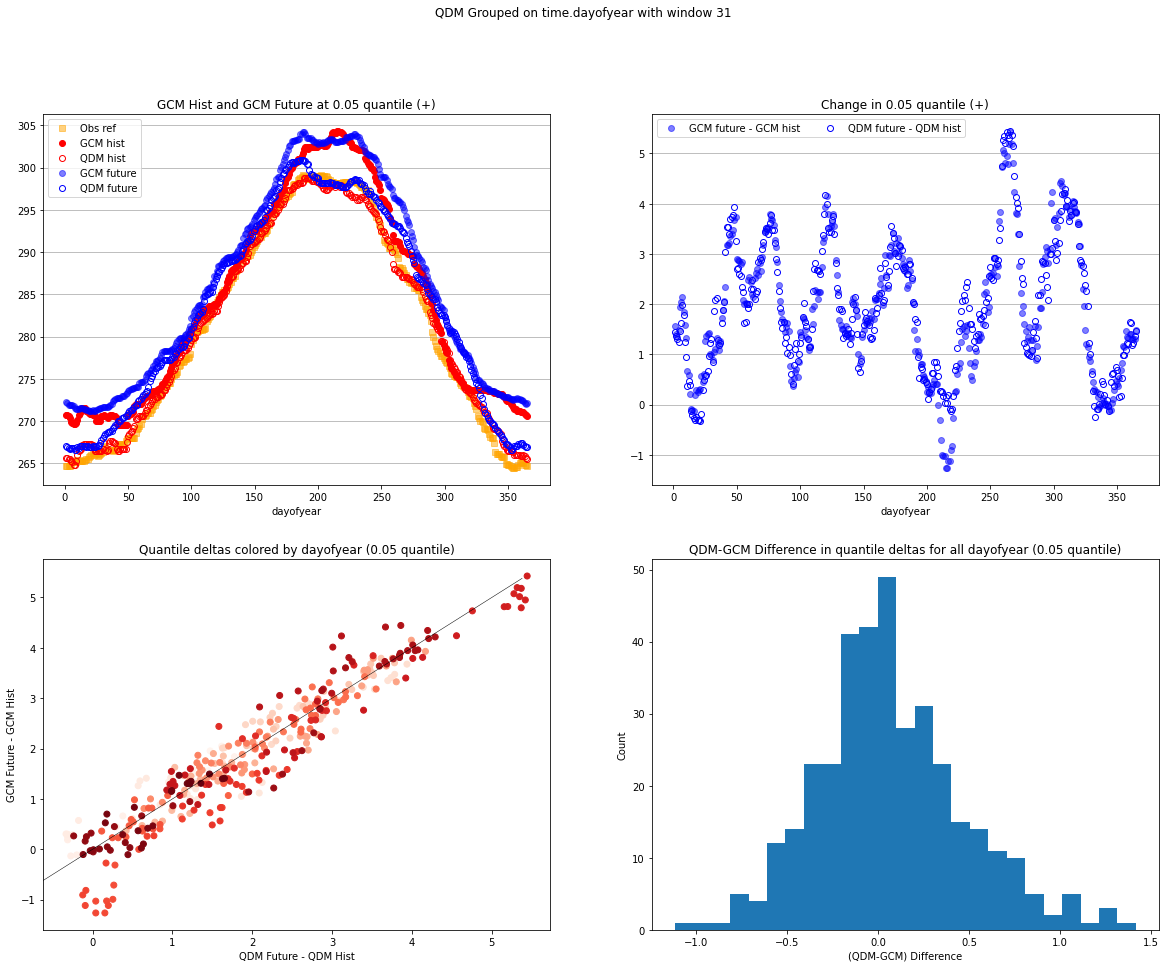

In [65]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.05], simple=True, tworow=True)

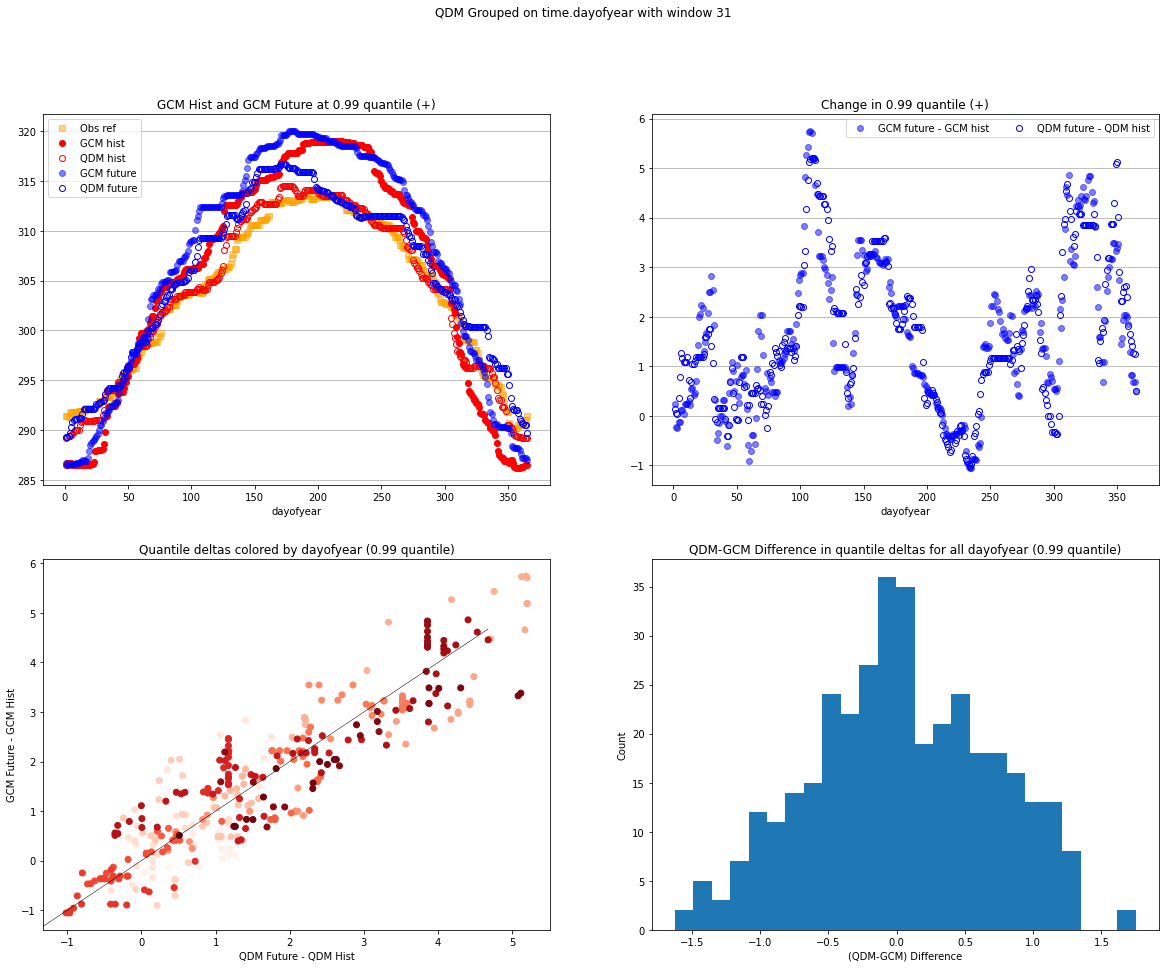

In [66]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

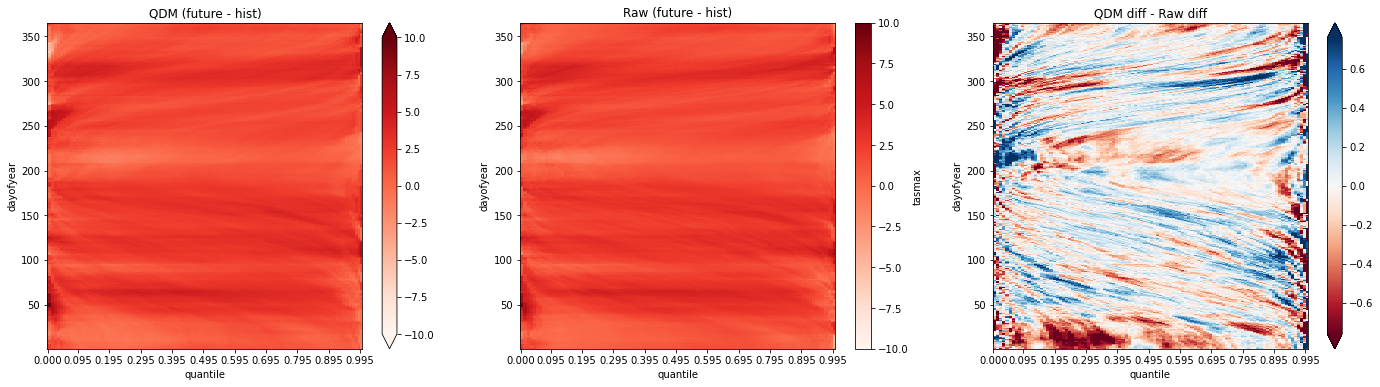

In [67]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=QDMdg.ds.quantiles)

interp='linear' 2040-2060

In [68]:
# what are the best keys to use? 'GCM hist', 'QDM hist', 'GCM future','QDM future' or what is here?
raw_dict = {'ref':ref,
           'hist':hist,
           'sim':sim.loc[dict(time=slice("%s-01-01" %str(2040), "%s-12-31" %str(2060)))]}
adjusted_dict = {'hist':hist_qdm_lin,
                'sim':simy_lin_qdm.loc[dict(time=slice("%s-01-01" %str(2040), "%s-12-31" %str(2060)))]}
bcgrouper = QDMdg.group

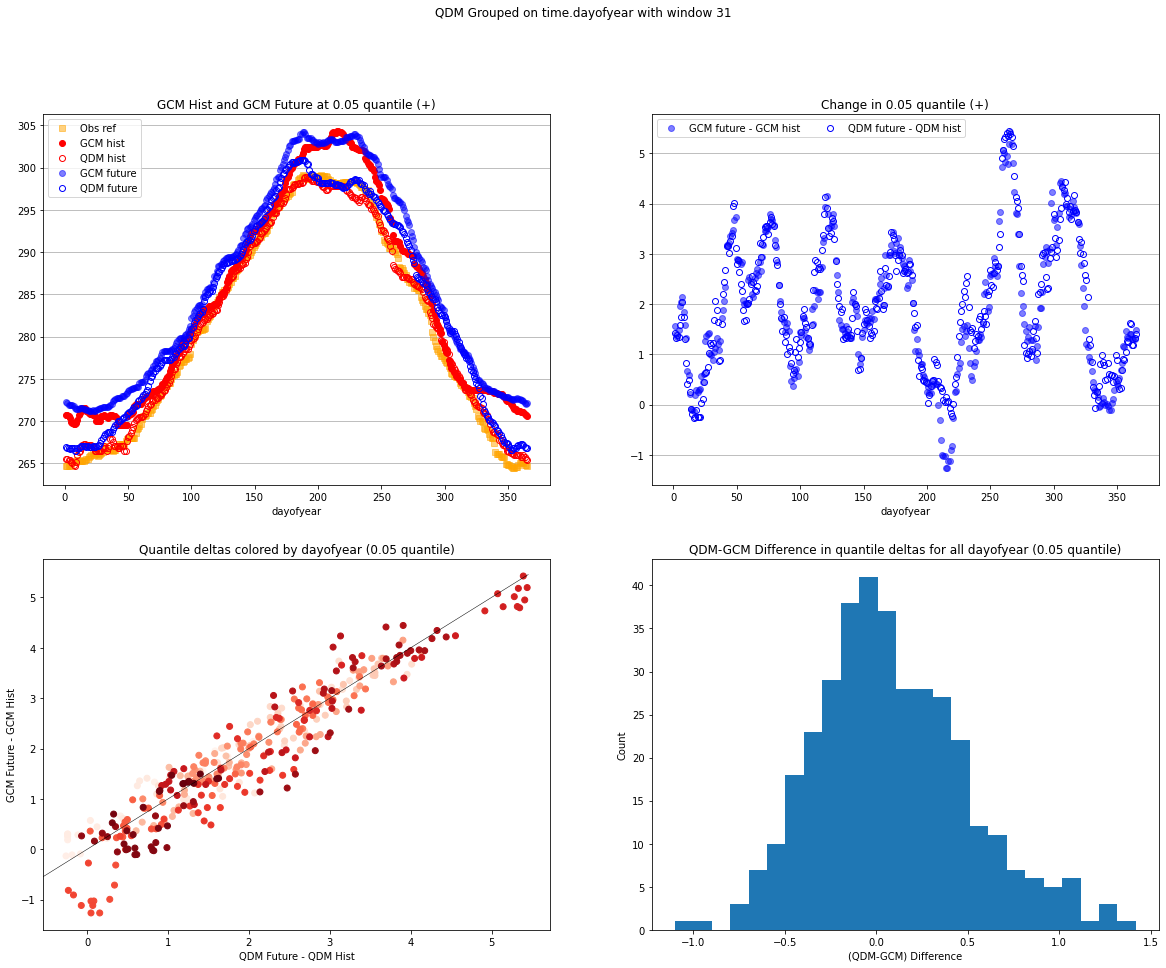

In [69]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.05], simple=True, tworow=True)

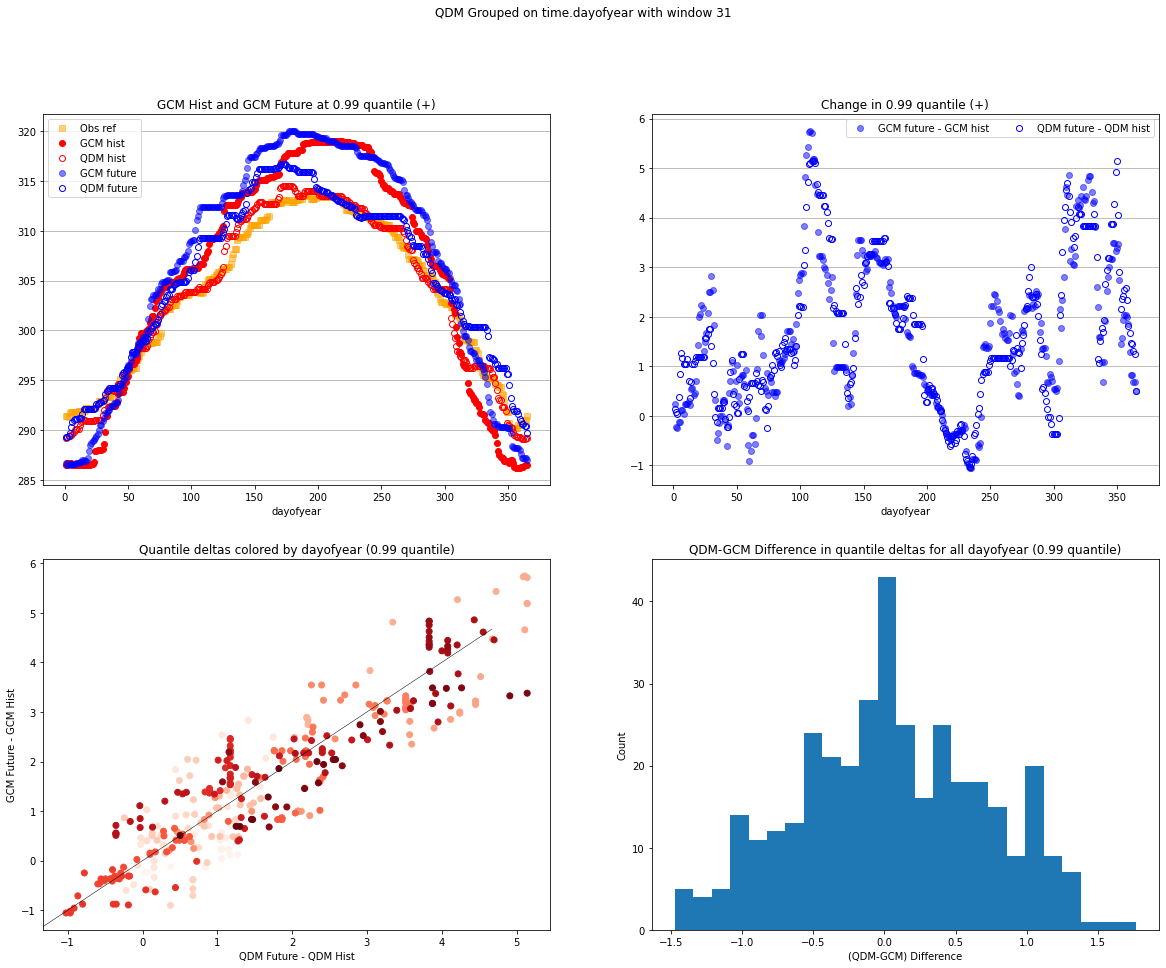

In [70]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

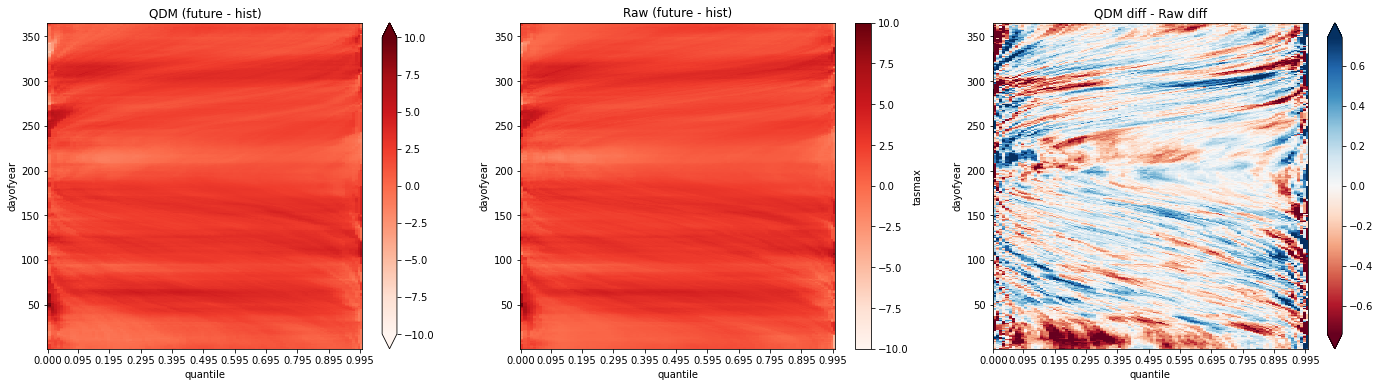

In [71]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=QDMdg.ds.quantiles)

interp='cubic' 2040-2060

In [72]:
# what are the best keys to use? 'GCM hist', 'QDM hist', 'GCM future','QDM future' or what is here?
raw_dict = {'ref':ref,
           'hist':hist,
           'sim':sim.loc[dict(time=slice("%s-01-01" %str(2040), "%s-12-31" %str(2060)))]}
adjusted_dict = {'hist':hist_qdm_cub,
                'sim':simy_cub_qdm.loc[dict(time=slice("%s-01-01" %str(2040), "%s-12-31" %str(2060)))]}
bcgrouper = QDMdg.group

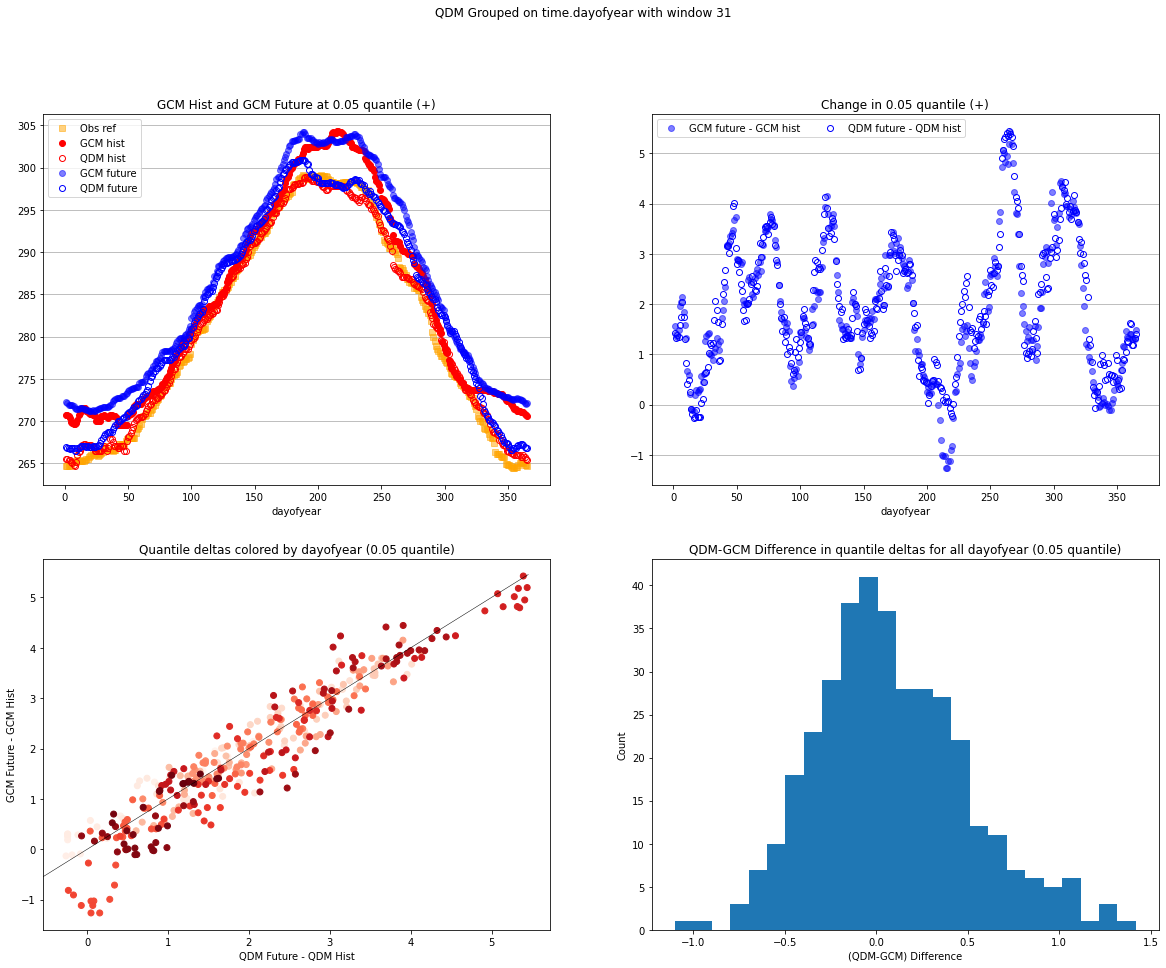

In [73]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.05], simple=True, tworow=True)

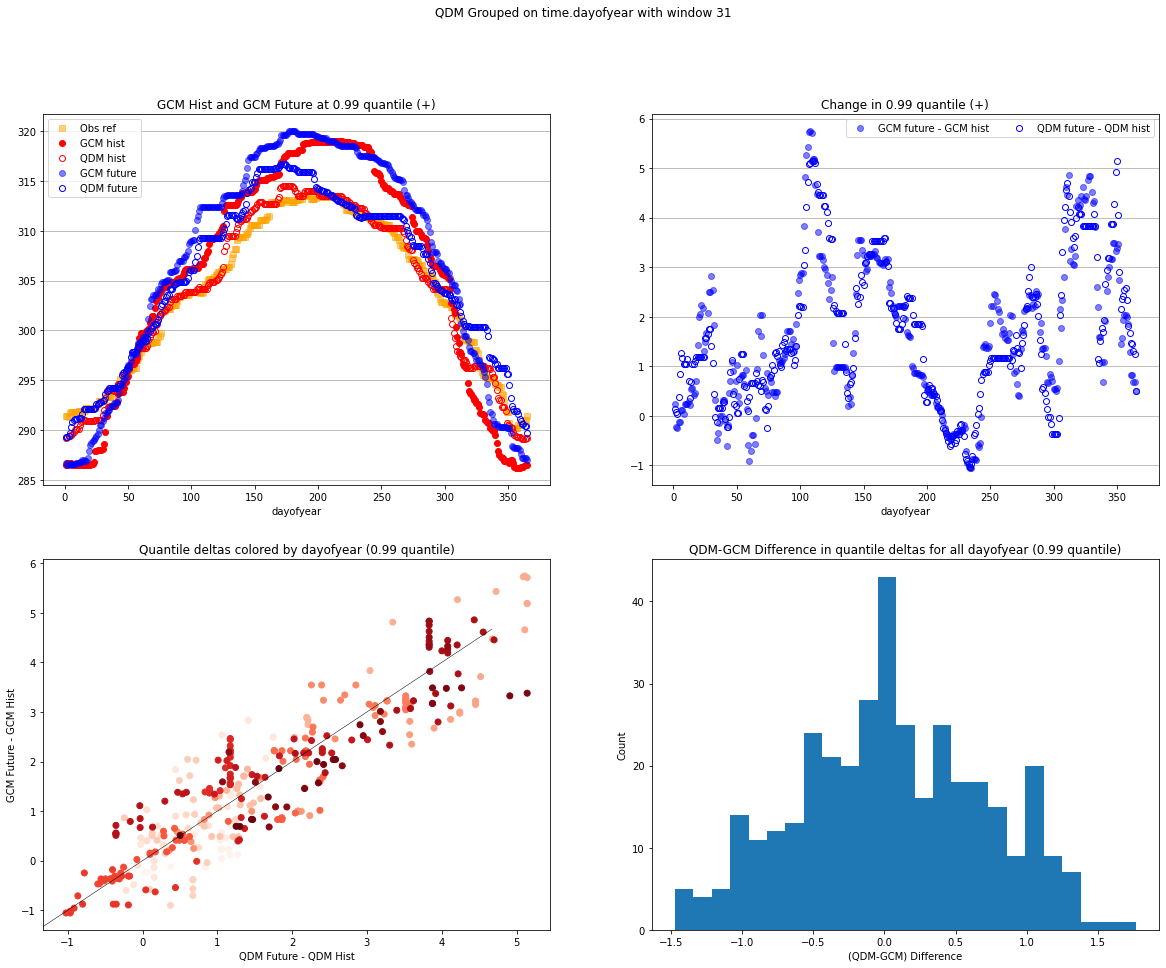

In [74]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

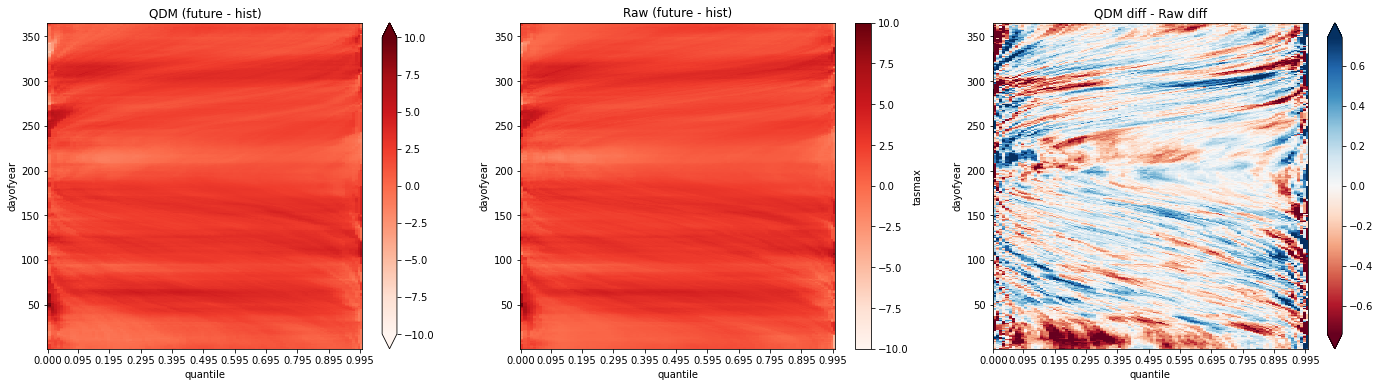

In [75]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=QDMdg.ds.quantiles)

Calculating the means changes across time

In [235]:
def calculate_trend_across_years(da_dict, time1, time2):
    annual_mean_all = []
    z_all = []
    p_all = []
    
    for i_da in range(0,len(da_dict)):
        da = da_dict[i_da].sel(time=slice(time1,time2))
        annual_mean = da.groupby(da.time.dt.year).mean()
        annual_mean_all.append(annual_mean)
        
        z = np.polyfit(annual_mean_all[i_da].year, annual_mean_all[i_da], 1)
        p = np.poly1d(z)
        z_all.append(z)
        p_all.append(p)
        
    return [annual_mean_all, z_all, p_all]

In [217]:
[annual_mean_hist, z_hist, p_hist] = calculate_trend_across_years([hist, hist_qdm, hist_qdm_lin, hist_qdm_cub], '1995-01-01', '2014-12-31')

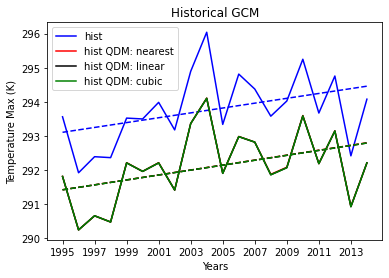

In [234]:
labels = ['hist', 'hist QDM: nearest', 'hist QDM: linear', 'hist QDM: cubic']
colors = ['b','r','k','g']

fig,ax = plt.subplots() # figure()

for i_da in range(0,len(annual_mean_hist)):
    plt.plot(annual_mean_hist[i_da].year, annual_mean_hist[i_da], colors[i_da], label=labels[i_da])
    plt.plot(annual_mean_hist[i_da].year, p_hist[i_da](annual_mean_hist[i_da].year), colors[i_da], linestyle='dashed')

xticks = np.arange(1995, 2015, 2)
ax.set_xticks(xticks)
plt.title('Historical GCM')
plt.ylabel("Temperature Max (K)")
plt.xlabel("Years")

plt.legend()

In [245]:
z_hist

[array([7.12255722e-02, 1.51009693e+02]),
 array([7.25626975e-02, 1.46656016e+02]),
 array([7.23003828e-02, 1.47177918e+02]),
 array([7.23003828e-02, 1.47177918e+02])]

In [237]:
[annual_mean_sim, z_sim, p_sim] = calculate_trend_across_years([sim, sim_qdm, sim_qdm_lin, sim_qdm_cub], '2015-01-01', '2100-12-31')

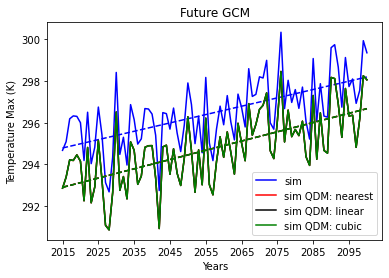

In [240]:
labels = ['sim', 'sim QDM: nearest', 'sim QDM: linear', 'sim QDM: cubic']
colors = ['b','r','k','g']

fig,ax = plt.subplots() # figure()

for i_da in range(0,len(annual_mean_sim)):
    plt.plot(annual_mean_sim[i_da].year, annual_mean_sim[i_da], colors[i_da], label=labels[i_da])
    plt.plot(annual_mean_sim[i_da].year, p_sim[i_da](annual_mean_sim[i_da].year), colors[i_da], linestyle='dashed')

xticks = np.arange(2015, 2100, 10)
ax.set_xticks(xticks)
plt.title('Future GCM')
plt.ylabel("Temperature Max (K)")
plt.xlabel("Years")

plt.legend()

In [246]:
z_sim

[array([4.00752249e-02, 2.14038650e+02]),
 array([4.43840565e-02, 2.03470213e+02]),
 array([4.44076247e-02, 2.03420227e+02]),
 array([4.44076247e-02, 2.03420227e+02])]

In [241]:
[annual_mean_simR, z_simR, p_simR] = calculate_trend_across_years([sim, simy_qdm, simy_lin_qdm, simy_cub_qdm], '2024-01-01', '2089-12-31')

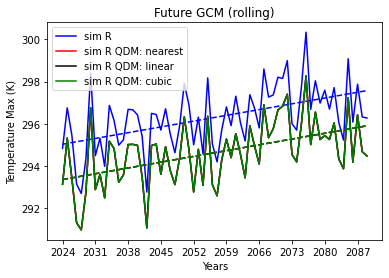

In [244]:
labels = ['sim R', 'sim R QDM: nearest', 'sim R QDM: linear', 'sim R QDM: cubic']
colors = ['b','r','k','g']

fig,ax = plt.subplots() # figure()

for i_da in range(0,len(annual_mean_sim)):
    plt.plot(annual_mean_simR[i_da].year, annual_mean_simR[i_da], colors[i_da], label=labels[i_da])
    plt.plot(annual_mean_simR[i_da].year, p_simR[i_da](annual_mean_simR[i_da].year), colors[i_da], linestyle='dashed')

xticks = np.arange(2024, 2089, 7)
ax.set_xticks(xticks)
plt.title('Future GCM (rolling)')
plt.ylabel("Temperature Max (K)")
plt.xlabel("Years")

plt.legend()

In [247]:
z_simR

[array([3.91964582e-02, 2.15689149e+02]),
 array([3.92510473e-02, 2.13902062e+02]),
 array([3.92613398e-02, 2.13880967e+02]),
 array([3.92613398e-02, 2.13880967e+02])]

Calculate the rolling average to include the +/-15 days for each dayofyear grouping

In [130]:
def assign_coords(da):
    noleap = da.where(~((da.time.dt.month == 2) & 
                        (da.time.dt.day == 29)), drop=True)
    
    years = np.arange(da.time.dt.year.min(),da.time.dt.year.max()+1)
    #if len(noleap.time) == len(np.arange(1,366))*len(years):
    da_wcoords = noleap.assign_coords(dayofyear=xr.DataArray(np.array([np.arange(1,366)]*len(years)).flatten(),
                                                dims=('time'),
                                                coords={'time':noleap.time})).persist()
    return da_wcoords

def rolling_31day_mean(da):
    roll = da.rolling(time=31, center=True).mean().dropna("time")
    roll_wcoords = assign_coords(roll)
    return roll_wcoords

def rolling_31day_minp_mean(da):
    roll = da.rolling(time=31, min_periods=15, center=True).mean()
    roll = roll.sel(time=slice('2015-01-01','2100-12-31'))
    roll_wcoords = assign_coords(roll)
    return roll_wcoords

In [107]:
ref_roll = rolling_31day_mean(ref)

hist_roll = rolling_31day_mean(hist)
hist_qdm_roll = rolling_31day_mean(hist_qdm)
hist_qdm_lin_roll = rolling_31day_mean(hist_qdm_lin)
hist_qdm_cub_roll = rolling_31day_mean(hist_qdm_cub)

In [131]:
sim_roll = rolling_31day_minp_mean(sim)
sim_qdm_roll = rolling_31day_minp_mean(sim_qdm)
sim_qdm_lin_roll = rolling_31day_minp_mean(sim_qdm_lin)
sim_qdm_cub_roll = rolling_31day_minp_mean(sim_qdm_cub)

simy_qdm_roll = rolling_31day_minp_mean(simy_qdm)
simy_qdm_lin_roll = rolling_31day_minp_mean(simy_lin_qdm)
simy_qdm_cub_roll = rolling_31day_minp_mean(simy_cub_qdm)

In [160]:
def transform_z_to_da(da):
    all_slopes = []
    
    for i_len in range(0,len(da)):

        z_values = da[i_len]
        all_slopes.append(z_values[0])
    
    all_slopes = xr.DataArray(all_slopes)
    return all_slopes

def group_calculate_trend(da):
    '''
    create function to create groups, loop through each day of grouping, calculate and save the trend (z,p)
    '''
    #pass da, create groups
    groups = da.groupby('dayofyear').groups
    
    z_dayofyear = []
    #p_dayofyear = []

    # loop through dict groups for indices corresponding to each dayofyear
    for days in range(1,len(groups)+1):
        indices = groups[days]

        all_dates = []
        # loop through each index for all dayofyear instances 
        for date in range(0,len(indices)):
            da_alldates = da[indices[date]]
            all_dates.append(da_alldates)

        # turn list into DataArray -- becomes the array over which to calculate the trend
        all_dates = xr.DataArray(all_dates)

        years = np.unique(da.time.dt.year)
        
        # calc the trend of each day across years
        z = np.polyfit(years, all_dates, 1)
        #p = np.poly1d(z)
        
        #print(z)
        #print(p)
        z_dayofyear.append(z)
        #p_dayofyear.append(p)
        
    slopes_z = transform_z_to_da(z_dayofyear)
    
    return slopes_z

Calculate the trend across each `dayofyear`

In [142]:
z_ref = group_calculate_trend(ref_roll)

In [143]:
# Histrorical GCM trends
z_hist = group_calculate_trend(hist_roll)
z_hist_qdm = group_calculate_trend(hist_qdm_roll)
z_hist_qdm_lin = group_calculate_trend(hist_qdm_lin_roll)
z_hist_qdm_cub = group_calculate_trend(hist_qdm_cub_roll)

In [144]:
# Single CDF future GCM trends
z_sim = group_calculate_trend(sim_roll)
z_sim_qdm = group_calculate_trend(sim_qdm_roll)
z_sim_qdm_lin = group_calculate_trend(sim_qdm_lin_roll)
z_sim_qdm_cub = group_calculate_trend(sim_qdm_cub_roll)

In [161]:
# Rolling CDF future GCM trends
z_simy_qdm = group_calculate_trend(simy_qdm_roll)
z_simy_qdm_lin = group_calculate_trend(simy_qdm_lin_roll)
z_simy_qdm_cub = group_calculate_trend(simy_qdm_cub_roll)

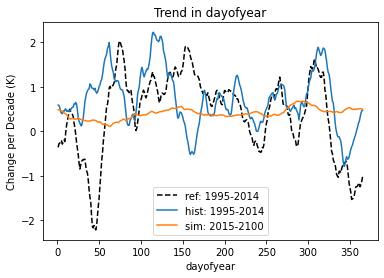

In [147]:
days = np.arange(1,366)

fig = plt.figure()
plt.plot(days, (z_ref*10), "k--", label='ref: 1995-2014')
plt.plot(days, (z_hist*10), label='hist: 1995-2014')
plt.plot(days, (z_sim*10), label='sim: 2015-2100')

plt.title('Trend in dayofyear')
plt.xlabel('dayofyear')
plt.ylabel('Change per Decade (K)')

plt.legend()

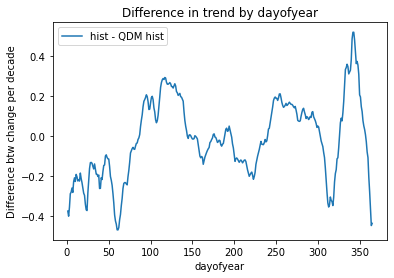

In [151]:
fig = plt.figure()

plt.plot(days, ((z_hist - z_hist_qdm)*10), label='hist - QDM hist')

plt.title('Difference in trend by dayofyear')
plt.xlabel('dayofyear')
plt.ylabel('Difference btw change per decade')

plt.legend()

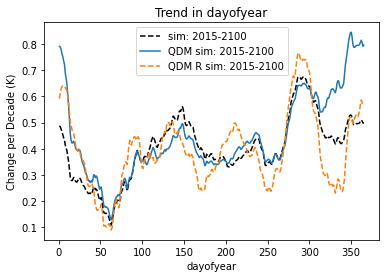

In [163]:
fig = plt.figure()

plt.plot(days, (z_sim*10), "k--", label='sim: 2015-2100')
plt.plot(days, (z_sim_qdm*10), label='QDM sim: 2015-2100')
plt.plot(days, (z_simy_qdm*10), linestyle='dashed', label='QDM R sim: 2015-2100')

plt.title('Trend in dayofyear')
plt.xlabel('dayofyear')
plt.ylabel('Change per Decade (K)')

plt.legend()

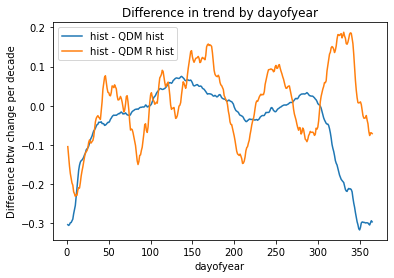

In [167]:
fig = plt.figure()

plt.plot(days, ((z_sim - z_sim_qdm)*10), label='hist - QDM hist')
plt.plot(days, ((z_sim - z_simy_qdm)*10), label='hist - QDM R hist')

plt.title('Difference in trend by dayofyear')
plt.xlabel('dayofyear')
plt.ylabel('Difference btw change per decade')

plt.legend()

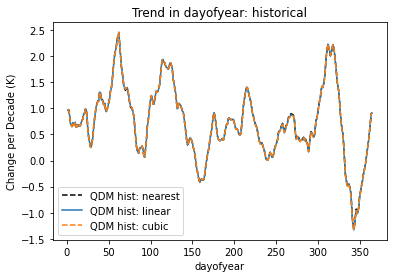

In [166]:
fig = plt.figure()

plt.plot(days, (z_hist_qdm*10), "k--", label='QDM hist: nearest')
plt.plot(days, (z_hist_qdm_lin*10), label='QDM hist: linear')
plt.plot(days, (z_hist_qdm_cub*10), linestyle='dashed', label='QDM hist: cubic')

plt.title('Trend in dayofyear: historical')
plt.xlabel('dayofyear')
plt.ylabel('Change per Decade (K)')

plt.legend()

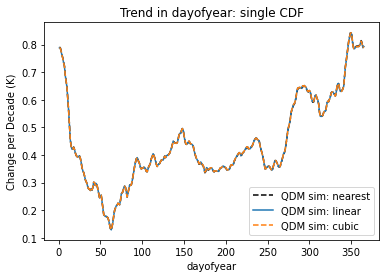

In [164]:
fig = plt.figure()

plt.plot(days, (z_sim_qdm*10), "k--", label='QDM sim: nearest')
plt.plot(days, (z_sim_qdm_lin*10), label='QDM sim: linear')
plt.plot(days, (z_sim_qdm_cub*10), linestyle='dashed', label='QDM sim: cubic')

plt.title('Trend in dayofyear: single CDF')
plt.xlabel('dayofyear')
plt.ylabel('Change per Decade (K)')

plt.legend()

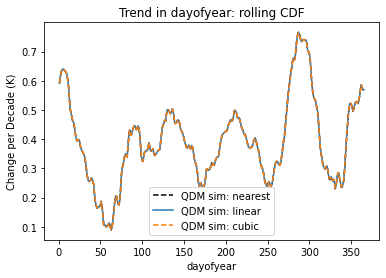

In [165]:
fig = plt.figure()

plt.plot(days, (z_simy_qdm*10), "k--", label='QDM sim: nearest')
plt.plot(days, (z_simy_qdm_lin*10), label='QDM sim: linear')
plt.plot(days, (z_simy_qdm_cub*10), linestyle='dashed', label='QDM sim: cubic')

plt.title('Trend in dayofyear: rolling CDF')
plt.xlabel('dayofyear')
plt.ylabel('Change per Decade (K)')

plt.legend()

Concatenate timeseries to plot and calculate trends across full time

In [259]:
gcm = xr.concat([hist_roll, sim_roll], dim='time')
qdm = xr.concat([hist_qdm_roll, sim_qdm_roll], dim='time')
qdm_lin = xr.concat([hist_qdm_lin_roll, sim_qdm_lin_roll], dim='time')
qdm_cub = xr.concat([hist_qdm_cub_roll, sim_qdm_cub_roll], dim='time')

qdmR = xr.concat([hist_qdm_roll, simy_qdm_roll], dim='time')
qdmR_lin = xr.concat([hist_qdm_lin_roll, simy_qdm_lin_roll], dim='time')
qdmR_cub = xr.concat([hist_qdm_cub_roll, simy_qdm_cub_roll], dim='time')

<xarray.DataArray (time: 31390)>
array([279.25869099, 279.8401837 , 280.29452176, ..., 278.42473154,
       278.47788603, 278.67879572])
Coordinates:
    lat        float64 40.0
    lon        float64 260.6
  * time       (time) object 1995-01-01 12:00:00 ... 2089-12-31 12:00:00
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    history:        2019-11-15T17:28:16Z altered by CMOR: Treated scalar dime...
    long_name:      Daily Maximum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    xclim_history:  2019-11-15T17:28:16Z altered by CMOR: Treated scalar dime...

In [278]:
gcm_mean = gcm.mean()
qdm_mean = qdm.mean()
qdm_lin_mean = qdm_lin.mean()
qdm_cub_mean = qdm_cub.mean()
qdmR_mean = qdmR.mean()
qdmR_lin_mean = qdmR_lin.mean()
qdmR_cub_mean = qdmR_cub.mean()

In [279]:
gcm_qdm_diff = gcm_mean - qdm_mean
gcm_qdmR_diff = gcm_mean - qdmR_mean
qdm_qdmR_diff = qdm_mean - qdmR_mean

near_lin_diff = qdm_mean - qdm_lin_mean
near_cub_diff = qdm_mean - qdm_cub_mean

Rnear_lin_diff = qdmR_mean - qdmR_lin_mean
Rnear_cub_diff = qdmR_mean - qdmR_cub_mean

In [294]:
Rnear_lin_diff

<xarray.DataArray ()>
array(0.00085195)
Coordinates:
    lat      float64 40.0
    lon      float64 260.6

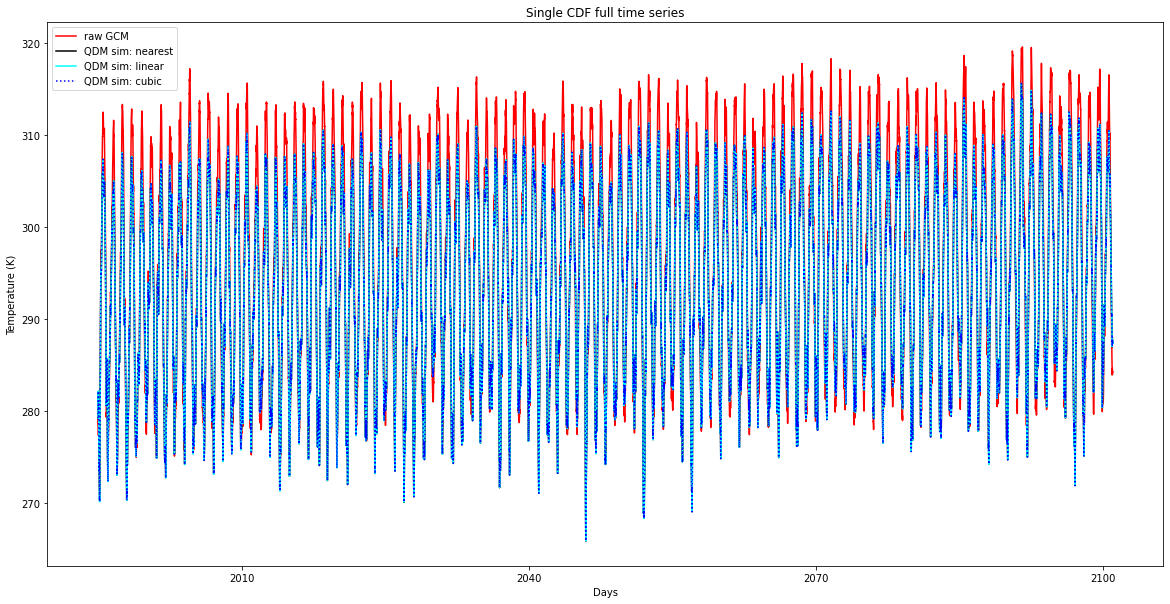

In [265]:
fig = plt.figure(figsize=(20,10))

plt.plot(gcm.time, gcm, "r", label='raw GCM')
plt.plot(qdm.time, qdm, color="black", label='QDM sim: nearest')
plt.plot(qdm_lin.time, qdm_lin, color="cyan", label='QDM sim: linear')
plt.plot(qdm_cub.time, qdm_cub, color="blue", linestyle=':', label='QDM sim: cubic')


plt.title('Single CDF: Full time series')
plt.xlabel('Days')
plt.ylabel('Temperature (K)')

plt.legend()

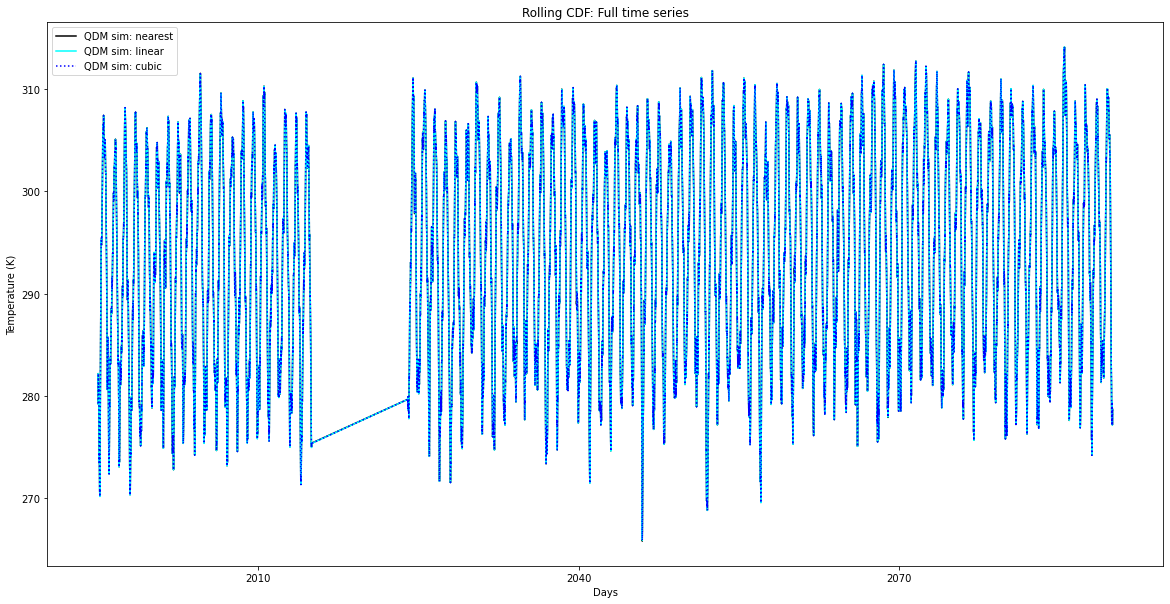

In [271]:
fig = plt.figure(figsize=(20,10))

#plt.plot(gcm.time, gcm, "r", label='raw GCM')
plt.plot(qdmR.time, qdmR, color="black", label='QDM sim: nearest')
plt.plot(qdmR.time, qdmR_lin, color="cyan", label='QDM sim: linear')
plt.plot(qdmR.time, qdmR_cub, color="blue", linestyle=':', label='QDM sim: cubic')


plt.title('Rolling CDF: Full time series')
plt.xlabel('Days')
plt.ylabel('Temperature (K)')

plt.legend()